In [1]:
import numpy as np
import scipy.io
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import statistics as st
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import roc_auc_score as auROC
from sklearn.metrics import f1_score
import sklearn.metrics as ms
import random
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
from scipy.ndimage import gaussian_filter1d



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Data preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE 

# Models
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# Model auxiliary
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Others
from statistics import mean
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import itertools
from multiprocessing import Pool, cpu_count
import pickle


In [2]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
base_dir = './extracted_data/Calcium/'

FR = 20
CueN = 12
BinSize = 6
TimeRange_before = 10
TimeRange_after = 10
Baseline_range = 10
Cueduration = 30
CompareRange_base = 0.5
CompareRange_after = 1.5

FrameRange_before = int(FR*TimeRange_before)
FrameRange_after = int(FR*TimeRange_after)
FrameRange_baseline = int(FR*Baseline_range)
TotalFrame = int(FrameRange_before+FrameRange_after)
Bins = int(TotalFrame/BinSize)
Bins_before = int(FrameRange_before/BinSize)
Baseline_bins = Bins_before - int(FrameRange_baseline/BinSize)
Bins_cueend = Bins_before+int(FR*Cueduration/BinSize)

In [6]:
def read_pkl_files(base_dir):
    dataframes = []
    pkl_files = [file for file in os.listdir(base_dir) if file.endswith('.pkl')]

    for pkl_file in pkl_files:
        file_path = os.path.join(base_dir, pkl_file)
        df = pd.read_pickle(file_path)

        # Reset index and use the original index as 'cell_id'
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'cell_id'}, inplace=True)
        
        # Extract animal ID from filename (assuming format 'AnimalID.pkl')
        animal_id = pkl_file.split('.')[0]
        
        # Add animal ID as a new column
        df['Animal_ID'] = animal_id

        # Reorder columns to make 'Animal_ID' front
        columns = ['Animal_ID', 'cell_id'] + [col for col in df.columns if col not in ['Animal_ID', 'cell_id']]
        df = df[columns]

        dataframes.append(df)

    return dataframes

all_dataframes = read_pkl_files(base_dir)

## Calculate trial-average zscores

In [7]:
def calculate_traces_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]
            
    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
#     trace = trace.sub(trace.mean(axis = 1), axis = 0).divide(trace.std(axis = 1), axis = 0)

    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(TotalFrame))

    # Aligning traces based on cue onset
    for i in range(TotalFrame):
        start = cueonset - FrameRange_before + i
        valid_starts = start[start >= 0]  # Ensure start is not negative
        tracenew.iloc[:, i] = trace.iloc[:, valid_starts].mean(axis=1)

    # Bin the traces
    tracebin = tracenew.groupby(pd.cut(tracenew.columns, Bins), axis=1).mean()
    tracebin.columns = np.arange(0, Bins)
    
    # Calculate the mean and std, handle the situation of 0 std
    mean_vals = tracebin.iloc[:, Baseline_bins:Bins_before].mean(axis=1)
    std_vals = tracebin.iloc[:, Baseline_bins:Bins_before].std(axis=1)
    
    # Create a mask where the mean is < 0.001 or std is < 0.001
    low_variance_mask = (std_vals < 0.001) #(mean_vals < 0.001) | (std_vals < 0.001)
    
    # Replace std values that are 0 with NaN, as well as where the mean is < 0.001
    std_vals_replaced = std_vals.mask(low_variance_mask, np.nan)
    
    # Calculate z-scores, NaN will result in the z-scores where std is zero
    tracezscore = tracebin.sub(mean_vals, axis=0).divide(std_vals_replaced, axis=0)
    
    # Replace NaN z-scores with 0, as these are the ones with std of 0
    tracezscore = tracezscore.fillna(0)

    return tracebin, tracezscore


In [8]:
hungrycue = 12

# Create a list to hold the dataframes
trace_hungry_list = []
trace_hungry_list_c = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin, tracesub = calculate_traces_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
    tracebin = pd.concat([tracebin, 
                      pd.Series(animal_id, index=tracebin.index, name='Animal_ID'), 
                      pd.Series(cell_ids, index=tracebin.index, name='cell_id')], axis=1)
    tracesub = pd.concat([tracesub, 
                      pd.Series(animal_id, index=tracesub.index, name='Animal_ID'), 
                      pd.Series(cell_ids, index=tracesub.index, name='cell_id')], axis=1)
    
    trace_hungry_list.append(tracesub)
    trace_hungry_list_c.append(tracebin)

# Concatenate all dataframes in the list
trace_hungry = pd.concat(trace_hungry_list, ignore_index=True)
trace_hungry_c = pd.concat(trace_hungry_list_c, ignore_index=True)
columns = ['Animal_ID', 'cell_id'] + [col for col in trace_hungry.columns if col not in ['Animal_ID', 'cell_id']]
trace_hungry = trace_hungry[columns]
trace_hungry_c = trace_hungry_c[columns]



In [9]:
satiatedcue = -12

# Create a list to hold the dataframes
trace_satiated_list = []
trace_satiated_list_c = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin, tracesub = calculate_traces_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=satiatedcue)
    tracebin = pd.concat([tracebin, 
                      pd.Series(animal_id, index=tracebin.index, name='Animal_ID'), 
                      pd.Series(cell_ids, index=tracebin.index, name='cell_id')], axis=1)
    tracesub = pd.concat([tracesub, 
                      pd.Series(animal_id, index=tracesub.index, name='Animal_ID'), 
                      pd.Series(cell_ids, index=tracesub.index, name='cell_id')], axis=1)
    
    trace_satiated_list.append(tracesub)
    trace_satiated_list_c.append(tracebin)

# Concatenate all dataframes in the list
trace_satiated = pd.concat(trace_satiated_list, ignore_index=True)
trace_satiated_c = pd.concat(trace_satiated_list_c, ignore_index=True)
columns = ['Animal_ID', 'cell_id'] + [col for col in trace_satiated.columns if col not in ['Animal_ID', 'cell_id']]
trace_satiated = trace_satiated[columns]
trace_satiated_c = trace_satiated_c[columns]



1111 neurons in hungry


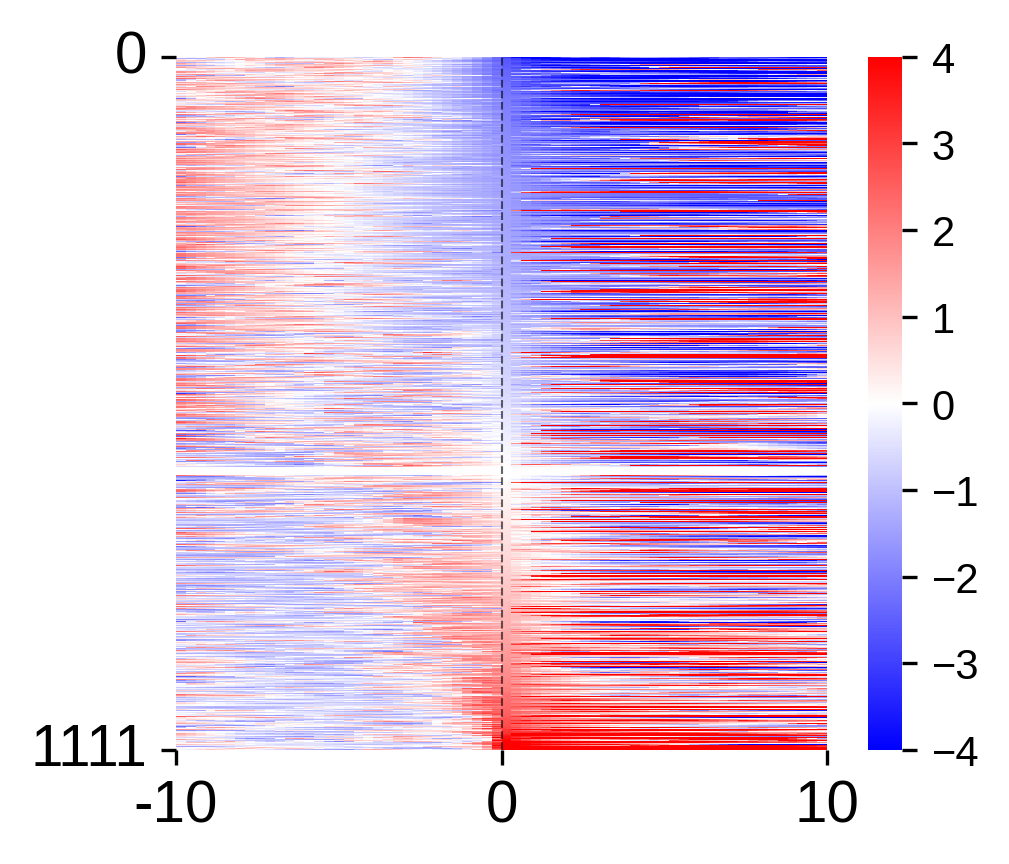

In [10]:
# Sorting and creating the heatmap
tracesorted = trace_hungry.sort_values(by=Bins_before, axis=0)
plt.figure(figsize=(3.5,3), dpi=300)
ax = sns.heatmap(tracesorted.iloc[:, 2:], vmin=-4, vmax=4, cmap="bwr")  # Exclude the last two columns (Animal_ID and cell_id)
ax.set_xticks([0, Bins_before, Bins])
ax.set_xticklabels([-TimeRange_before, 0, TimeRange_after])
ax.set_yticks([0, len(tracesorted)])
ax.set_yticklabels([0, len(tracesorted)])
ax.tick_params(labelsize = 14)
ax.axvline(Bins_before, ls = '--', lw = 0.5, c = 'black', alpha = 0.6)
print(f"{len(trace_hungry)} neurons in hungry")

plt.show()

1111 neurons in satiated


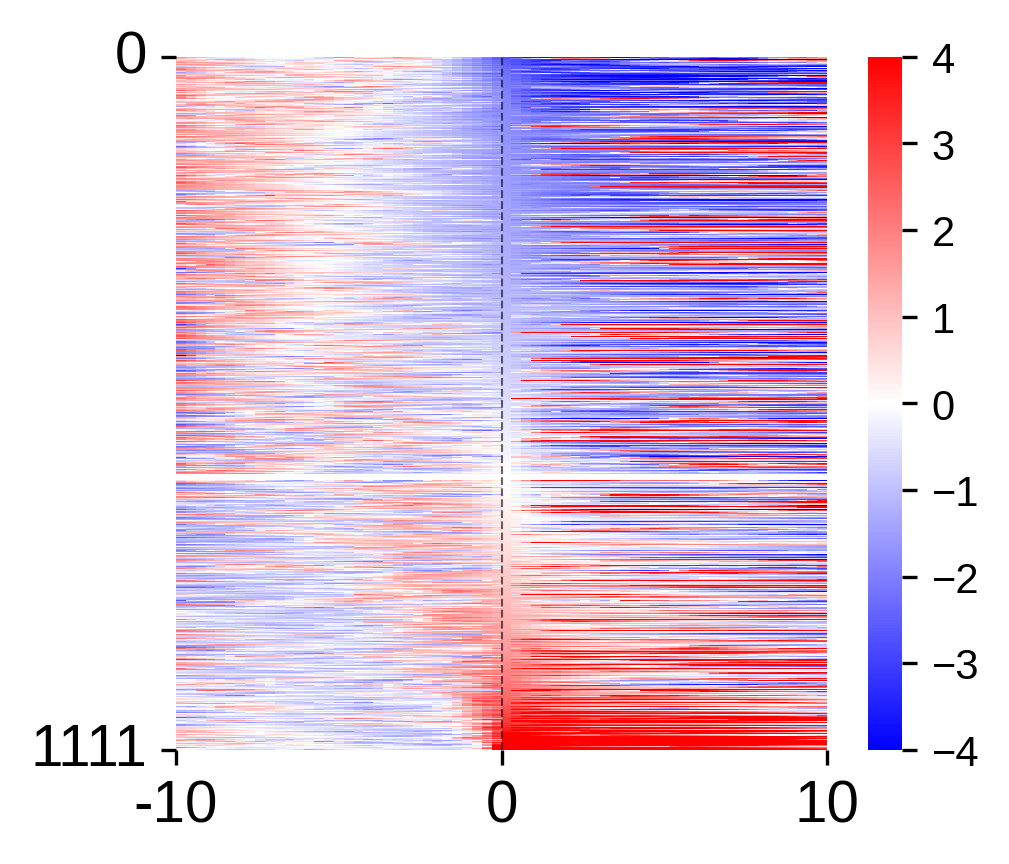

In [11]:
# Sorting and creating the heatmap
tracesorted = trace_satiated.sort_values(by=Bins_before, axis=0)
plt.figure(figsize=(3.5,3), dpi=300)
ax = sns.heatmap(tracesorted.iloc[:, 2:], vmin=-4, vmax=4, cmap="bwr")  # Exclude the last two columns (Animal_ID and cell_id)
ax.set_xticks([0, Bins_before, Bins])
ax.set_xticklabels([-TimeRange_before, 0, TimeRange_after])
ax.set_yticks([0, len(tracesorted)])
ax.set_yticklabels([0, len(tracesorted)])
ax.tick_params(labelsize = 14)
ax.axvline(Bins_before, ls = '--', lw = 0.5, c = 'black', alpha = 0.6)
print(f"{len(trace_hungry)} neurons in satiated")

plt.show()

## Trial concatenate zscore by trial

In [12]:
def process_trial(args):
    trace_trial, Bins, Baseline_bins, Bins_before = args
    traceb_trial_binned = trace_trial.groupby(pd.cut(trace_trial.columns, Bins), axis=1).mean()
    mean_vals = traceb_trial_binned.iloc[:, Baseline_bins:Bins_before].mean(axis=1)
    std_vals = traceb_trial_binned.iloc[:, Baseline_bins:Bins_before].std(axis=1)
    low_variance_mask = (std_vals < 0.001)
    std_vals_replaced = std_vals.mask(low_variance_mask, np.nan)

    traceb_trial_zscore = traceb_trial_binned.sub(mean_vals, axis=0).divide(std_vals_replaced, axis=0)
    traceb_trial_zscore.fillna(0, inplace=True)

    return traceb_trial_zscore

def calculate_zscore_by_trial(tracenew_bycue, cueonset):
    trials = [(tracenew_bycue.iloc[:, i*TotalFrame: (i+1)*TotalFrame], Bins, Baseline_bins, Bins_before) for i in range(len(cueonset))]
    num_processes = os.cpu_count()
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_processes) as executor:
        results = executor.map(process_trial, trials)

    tracezscore = pd.concat(list(results), axis=1)
    return tracezscore


def calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]

    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]

    # Collect trace data slices in a list
    trace_slices = []
    for i, onset in enumerate(cueonset):
        valid_starts = np.arange(onset - FrameRange_before, onset + FrameRange_after)
        valid_starts = valid_starts[(valid_starts >= 0) & (valid_starts < len(trace.columns))]
        trace_slices.append(trace.iloc[:, valid_starts])

    # Concatenate all slices
    tracenew_bycue = pd.concat(trace_slices, axis=1)

    tracezscore_bycue = calculate_zscore_by_trial(tracenew_bycue, cueonset)
    tracezscore_bycue.columns = np.arange(0, Bins*len(cueonset))
    
    return tracezscore_bycue


In [13]:
%%time
hungrycue = 12
trial_size = TotalFrame

# Create a list to hold the dataframes
trace_hungry_trial_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin = calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=hungrycue)

    # Add animal ID and cell IDs
    tracebin = pd.concat([tracebin, 
                      pd.Series(animal_id, index=tracebin.index, name='Animal_ID'), 
                      pd.Series(cell_ids, index=tracebin.index, name='cell_id')], axis=1)

    # Store the updated DataFrame in the list
    trace_hungry_trial_list.append(tracebin)
    
# Concatenate all dataframes in the list with appropriate column order
trace_hungry_trial_zscored = pd.concat(trace_hungry_trial_list, ignore_index=True)
columns = ['Animal_ID', 'cell_id'] + [col for col in trace_hungry_trial_zscored.columns if col not in ['Animal_ID', 'cell_id']]
trace_hungry_trial_zscored = trace_hungry_trial_zscored[columns]

CPU times: user 2.82 s, sys: 14.3 s, total: 17.1 s
Wall time: 22.6 s


In [14]:
trace_hungry_trial_zscored

Animal_ID cell_id         0         1         2         3         4  \
0          6S5       1  2.037222  1.835438  1.657299  1.486523  1.322807   
1          6S5       2  1.189321  0.991200  0.818506  0.654932  0.499995   
2          6S5       3 -1.751388 -1.819759 -1.882150 -1.943866 -1.907157   
3          6S5       4  0.004340 -0.216623 -0.407909 -0.587813 -0.757010   
4          6S5       5  2.939370  2.151601  1.478092  0.851720  0.269183   
...        ...     ...       ...       ...       ...       ...       ...   
1106       8H6      63  0.000000  0.000000  0.000000  0.000000  0.000000   
1107       8H6      71 -1.001932 -1.017023 -1.029812 -1.041608 -1.052487   
1108       8H6      73  0.000000  0.000000  0.000000  0.000000  0.000000   
1109       8H6      75  2.538170  1.966359  1.517038  1.131162  0.799775   
1110       8H6      97  0.000000  0.000000  0.000000  0.000000  0.000000   

             5         6         7  ...       782       783       784  \
0     1.165858  1.015396  0.871154  ...  6.369206  7.183224  8.355363   
1     0.353241  0.214236  0.082571  ...  0.035822 -0.281370 -0.581813   
2    -0.356096  0.682537  1.429539  ...  1.316697  1.142009  0.969210   
3    -0.513219 -0.686856 -0.605167  ...  0.000000  0.000000  0.000000   
4    -0.272585 -0.776437 -1.190573  ... -1.693211 -1.873532 -1.217690   
...        ...       ...       ...  ...       ...       ...       ...   
1106  0.000000  0.000000  0.000000  ... -1.210738 -1.212827 -1.214739   
1107 -1.062521 -1.071775 -1.080310  ...  0.000000  0.000000  0.000000   
1108  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1109  0.515181  0.270773  0.133675  ...  0.000000  0.000000  0.000000   
1110  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

           785       786       787       788       789       790       791  
0     7.907715  8.092549  8.461673  8.009631  7.576274  7.160831  6.730370  
1    -0.354053  2.017508  1.643636  1.256062  2.394435  2.332229  1.858640  
2     0.798281  1.449558  4.229741  4.023547  3.847224  3.700149  3.483108  
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4    -0.821736 -1.063046 -1.287468 -0.614924  0.913735  0.706942  0.331112  
...        ...       ...       ...       ...       ...       ...       ...  
1106 -1.216488 -1.218089 -1.219554 -1.220894 -1.222120 -1.223242 -1.224349  
1107  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1108  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1109  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1110  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[1111 rows x 794 columns]

In [15]:
%%time
satiatedcue = -12
trial_size = TotalFrame

# Create a list to hold the dataframes
trace_satiated_trial_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin = calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=satiatedcue)

    # Add animal ID and cell IDs
    tracebin = pd.concat([tracebin, 
                      pd.Series(animal_id, index=tracebin.index, name='Animal_ID'), 
                      pd.Series(cell_ids, index=tracebin.index, name='cell_id')], axis=1)

    # Store the updated DataFrame in the list
    trace_satiated_trial_list.append(tracebin)
    
# Concatenate all dataframes in the list with appropriate column order
trace_satiated_trial_zscored = pd.concat(trace_satiated_trial_list, ignore_index=True)
columns = ['Animal_ID', 'cell_id'] + [col for col in trace_satiated_trial_zscored.columns if col not in ['Animal_ID', 'cell_id']]
trace_satiated_trial_zscored = trace_satiated_trial_zscored[columns]

CPU times: user 2.88 s, sys: 14.1 s, total: 17 s
Wall time: 22.7 s


## Trial concatenate

In [16]:
def calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]
           
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    trace = trace.sub(trace.mean(axis = 1), axis = 0).divide(trace.std(axis = 1), axis = 0)
    trace = trace.fillna(0)


    # Collect trace data slices in a list
    trace_slices = []
    for i, onset in enumerate(cueonset):
        valid_starts = np.arange(onset - FrameRange_before, onset + FrameRange_after)
        valid_starts = valid_starts[(valid_starts >= 0) & (valid_starts < len(trace.columns))]
        trace_slices.append(trace.iloc[:, valid_starts])
        
        # Concatenate all slices
    concatenated_trace_df = pd.concat(trace_slices, axis=1)

    # Bin the traces
    tracebin = concatenated_trace_df.groupby(pd.cut(concatenated_trace_df.columns, Bins*len(cueonset)), axis=1).mean()
    tracebin = tracebin.fillna(0)
    tracebin.columns = np.arange(0, Bins*len(cueonset))
    
    return tracebin

def calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]
           
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    trace = trace.sub(trace.mean(axis = 1), axis = 0).divide(trace.std(axis = 1), axis = 0)
    trace = trace.fillna(0)

    # Collect trace data slices in a list
    trace_slices = []
    for i, onset in enumerate(cueonset):
        valid_starts = np.arange(onset - FrameRange_before, onset + FrameRange_after)
        valid_starts = valid_starts[(valid_starts >= 0) & (valid_starts < len(trace.columns))]
        trace_slice = trace.iloc[:, valid_starts]
        trace_slice_bin = trace_slice.groupby(pd.cut(trace_slice.columns, Bins), axis=1).mean()
        trace_slices.append(trace_slice_bin)
        
        # Concatenate all slices
    concatenated_trace_df = pd.concat(trace_slices, axis=1)

    # Bin the traces
#     tracebin = concatenated_trace_df.groupby(pd.cut(concatenated_trace_df.columns, Bins*len(cueonset)), axis=1).mean()
#     tracebin = tracebin.fillna(0)
    concatenated_trace_df.columns = np.arange(0, Bins*len(cueonset))
    
    return concatenated_trace_df

In [17]:
hungrycue = 12

# Create a list to hold the dataframes
trace_hungry_trial_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin = calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
    tracebin['Animal_ID'] = animal_id  # Add animal ID
    tracebin['cell_id'] = cell_ids  # Add cell IDs
    
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracebin.columns if col not in ['Animal_ID', 'cell_id']]
    tracebin = tracebin[columns]
    
    trace_hungry_trial_list.append(tracebin)

# Concatenate all dataframes in the list
trace_hungry_trial = pd.concat(trace_hungry_trial_list, ignore_index=True)


In [18]:
trace_hungry_trial

Animal_ID cell_id         0         1         2         3         4  \
0          6S5       1 -0.720246 -0.734613 -0.747296 -0.759455 -0.771112   
1          6S5       2  0.689864  0.610469  0.541264  0.475713  0.413624   
2          6S5       3  0.225793  0.214937  0.205030  0.195230  0.201059   
3          6S5       4  0.717429  0.645040  0.582373  0.523435  0.468004   
4          6S5       5  0.667347  0.561886  0.471722  0.387867  0.309881   
...        ...     ...       ...       ...       ...       ...       ...   
1106       8H6      63 -0.233992 -0.233992 -0.233992 -0.233992 -0.233992   
1107       8H6      71 -0.254450 -0.260407 -0.265456 -0.270112 -0.274407   
1108       8H6      73 -0.101434 -0.101434 -0.101434 -0.101434 -0.101434   
1109       8H6      75  2.824571  2.375170  2.022036  1.718766  1.458320   
1110       8H6      97 -0.110038 -0.110038 -0.110038 -0.110038 -0.110038   

             5         6         7  ...       782       783       784  \
0    -0.782286 -0.792999 -0.803269  ... -0.783167 -0.759393 -0.725159   
1     0.354813  0.299108  0.246345  ... -0.247075 -0.270996 -0.293653   
2     0.447347  0.612269  0.730882  ... -0.301636 -0.305956 -0.310229   
3     0.547872  0.490987  0.517750  ... -0.408054 -0.408054 -0.408054   
4     0.237353  0.169901  0.114459  ... -0.533495 -0.546999 -0.497881   
...        ...       ...       ...  ...       ...       ...       ...   
1106 -0.233992 -0.233992 -0.233992  ... -0.231738 -0.231929 -0.232105   
1107 -0.278368 -0.282021 -0.285391  ... -0.325392 -0.325392 -0.325392   
1108 -0.101434 -0.101434 -0.101434  ... -0.101434 -0.101434 -0.101434   
1109  1.234650  1.042563  0.934814  ...  1.487154  1.259413  1.063829   
1110 -0.110038 -0.110038 -0.110038  ... -0.110038 -0.110038 -0.110038   

           785       786       787       788       789       790       791  
0    -0.738233 -0.732834 -0.722054 -0.735256 -0.747913 -0.760047 -0.772619  
1    -0.276477 -0.097630 -0.125825 -0.155053 -0.069204 -0.073896 -0.109611  
2    -0.314456 -0.298350 -0.229599 -0.234698 -0.239059 -0.242696 -0.248063  
3    -0.408054 -0.408054 -0.408054 -0.408054 -0.408054 -0.408054 -0.408054  
4    -0.468226 -0.486299 -0.503107 -0.452737 -0.338250 -0.353737 -0.381885  
...        ...       ...       ...       ...       ...       ...       ...  
1106 -0.232265 -0.232412 -0.232546 -0.232669 -0.232781 -0.232884 -0.232986  
1107 -0.325392 -0.325392 -0.325392 -0.325392 -0.325392 -0.325392 -0.325392  
1108 -0.101434 -0.101434 -0.101434 -0.101434 -0.101434 -0.101434 -0.101434  
1109  0.895863  0.751615  0.627735  0.521348  0.429983  0.351520  0.279111  
1110 -0.110038 -0.110038 -0.110038 -0.110038 -0.110038 -0.110038 -0.110038  

[1111 rows x 794 columns]

In [19]:
satiatedcue = -12

# Create a list to hold the dataframes
trace_satiated_trial_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracebin = calculate_traces_concatenated_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=satiatedcue)
    tracebin['Animal_ID'] = animal_id  # Add animal ID
    tracebin['cell_id'] = cell_ids  # Add cell IDs
    
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracebin.columns if col not in ['Animal_ID', 'cell_id']]
    tracebin = tracebin[columns]
    
    trace_satiated_trial_list.append(tracebin)

# Concatenate all dataframes in the list
trace_satiated_trial = pd.concat(trace_satiated_trial_list, ignore_index=True)

## Trial response

In [20]:
def calculate_1s_after_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=None):
    # Identifying cue onsets
    cue = df[df['cell_id'] == 'Tone active'].iloc[:, 2:].squeeze()
    cueonset = np.array(np.where(np.diff(np.concatenate(([0], cue > 0))) > 0)[0])
    if cue_range is not None:
        # Select a subset of cueonset based on cue_range
        if cue_range>0:
            cueonset = cueonset[:cue_range]
        elif cue_range<0:
            cueonset = cueonset[cue_range:]
    # Select rows where 'cell_id' is numeric and columns from the third column onwards
    trace = df[df['cell_id'].astype(str).str.isnumeric()].iloc[:, 2:]
    epsilon = 1e-8  # small value to prevent division by zero
    trace = trace.sub(trace.min(axis=1), axis = 0)/ (trace.max(axis=1) - trace.min(axis=1) + epsilon).values.reshape(-1, 1)

    tracenew = pd.DataFrame(0, index = trace.index, columns= np.arange(len(cueonset)))

    # Aligning traces based on cue onset     
    for i in range(len(cueonset)):
        tracenew.iloc[:,i] = trace.iloc[:,cueonset[i]:cueonset[i]+int(1.5*FR)].mean(axis=1)


    return tracenew

In [21]:
hungrycue = 12

# Create a list to hold the dataframes
trace_hungry_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracenew = calculate_1s_after_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=hungrycue)
    tracenew['Animal_ID'] = animal_id  # Add animal ID
    tracenew['cell_id'] = cell_ids  # Add cell IDs

    
    # Reorder columns to make 'Animal_ID' front
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracenew.columns if col not in ['Animal_ID', 'cell_id']]
    tracenew = tracenew[columns]

    trace_hungry_list.append(tracenew)

# Concatenate all dataframes in the list
tracehungry = pd.concat(trace_hungry_list, ignore_index=True)
tracehungry

Animal_ID cell_id         0         1             2         3         4  \
0          6S5       1  0.011445  0.000251  6.700778e-02  0.001125  0.263963   
1          6S5       2  0.131075  0.127352  7.643270e-02  0.041809  0.062237   
2          6S5       3  0.098118  0.076452  8.337234e-02  0.035533  0.044163   
3          6S5       4  0.089326  0.008902  1.323297e-04  0.000000  0.000000   
4          6S5       5  0.138732  0.121710  1.883752e-01  0.041213  0.047877   
...        ...     ...       ...       ...           ...       ...       ...   
1106       8H6      63  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
1107       8H6      71  0.016073  0.188046  9.958540e-02  0.000323  0.074007   
1108       8H6      73  0.000000  0.000000  2.070118e-10  0.000000  0.000000   
1109       8H6      75  0.001731  0.000000  0.000000e+00  0.000000  0.000000   
1110       8H6      97  0.000000  0.000000  0.000000e+00  0.000000  0.000000   

             5         6         7         8         9        10            11  
0     0.149300  0.003271  0.007544  0.070593  0.041640  0.001573  4.694824e-03  
1     0.032626  0.082860  0.135905  0.039275  0.115129  0.064668  8.790981e-02  
2     0.035087  0.038847  0.048301  0.112356  0.127032  0.037260  2.963185e-02  
3     0.000000  0.000000  0.000000  0.002957  0.000023  0.000318  1.693458e-09  
4     0.053921  0.050410  0.033290  0.116231  0.081114  0.063849  8.099859e-02  
...        ...       ...       ...       ...       ...       ...           ...  
1106  0.000972  0.124026  0.000081  0.000000  0.000000  0.000000  1.252356e-03  
1107  0.009905  0.000124  0.000558  0.002185  0.178336  0.000012  1.325206e-08  
1108  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00  
1109  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.113090e-01  
1110  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000e+00  

[1111 rows x 14 columns]

In [22]:
hungry_trace = pd.DataFrame()

for i in range(12):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array(["True"])
    dff["dff"]= [np.array(tracehungry[i].values)]
    
    hungry_trace = pd.concat([hungry_trace,dff],axis=0) 
hungry_trace

is_hungry                                                dff
0      True  [0.011445024730451408, 0.1310747284574947, 0.0...
0      True  [0.0002511570179862742, 0.12735226623322313, 0...
0      True  [0.0670077829419776, 0.07643269590843642, 0.08...
0      True  [0.0011250826589288387, 0.041809484524554796, ...
0      True  [0.26396318068890057, 0.062236625992541, 0.044...
0      True  [0.1492999678992333, 0.03262622276938556, 0.03...
0      True  [0.003270993122431044, 0.08285988972498805, 0....
0      True  [0.007544309466447821, 0.13590480846783662, 0....
0      True  [0.07059255308419934, 0.039275226142976204, 0....
0      True  [0.0416395388136461, 0.11512899875049079, 0.12...
0      True  [0.0015733110422076469, 0.06466756141366375, 0...
0      True  [0.004694823731464078, 0.08790980752975366, 0....

In [23]:

# Create a list to hold the dataframes
trace_satiated_list = []

# Loop through each animal's DataFrame
for df in all_dataframes:
    animal_id = df['Animal_ID'].iloc[0]  # Extract animal ID
    cell_ids = df['cell_id']  # Extract cell IDs

    tracenew = calculate_1s_after_zscore(df, FrameRange_before, TotalFrame, Bins, Bins_before, cue_range=satiatedcue)
    tracenew['Animal_ID'] = animal_id  # Add animal ID
    tracenew['cell_id'] = cell_ids  # Add cell IDs

    
    # Reorder columns to make 'Animal_ID' front
    columns = ['Animal_ID', 'cell_id'] + [col for col in tracenew.columns if col not in ['Animal_ID', 'cell_id']]
    tracenew = tracenew[columns]

    trace_satiated_list.append(tracenew)

# Concatenate all dataframes in the list
tracesatiated = pd.concat(trace_satiated_list, ignore_index=True)
tracesatiated

Animal_ID cell_id         0         1         2         3         4  \
0          6S5       1  0.155497  0.187339  0.271139  0.303564  0.269121   
1          6S5       2  0.035624  0.007010  0.029505  0.057410  0.046723   
2          6S5       3  0.036775  0.031579  0.052382  0.045853  0.040733   
3          6S5       4  0.002251  0.002732  0.024749  0.032251  0.008382   
4          6S5       5  0.701103  0.050993  0.004205  0.020553  0.009606   
...        ...     ...       ...       ...       ...       ...       ...   
1106       8H6      63  0.000000  0.000000  0.000000  0.004964  0.000304   
1107       8H6      71  0.000000  0.000000  0.000000  0.003230  0.000000   
1108       8H6      73  0.000000  0.000000  0.000000  0.000000  0.000000   
1109       8H6      75  0.000000  0.000000  0.000000  0.000006  0.000000   
1110       8H6      97  0.000000  0.000000  0.000000  0.000000  0.000000   

             5         6         7             8         9        10        11  
0     0.243233  0.131048  0.231117  3.563743e-01  0.312487  0.249207  0.169797  
1     0.023513  0.029252  0.152263  1.536627e-02  0.038663  0.049550  0.209119  
2     0.028128  0.092104  0.033107  4.841228e-02  0.031890  0.118647  0.029556  
3     0.000602  0.644121  0.005859  7.490988e-03  0.001155  0.336190  0.032897  
4     0.056366  0.000099  0.131623  2.894820e-02  0.015442  0.000877  0.261166  
...        ...       ...       ...           ...       ...       ...       ...  
1106  0.007660  0.000000  0.029837  3.095614e-08  0.000000  0.000000  0.000000  
1107  0.000000  0.000000  0.000000  7.703524e-08  0.000000  0.000000  0.000000  
1108  0.000000  0.000000  0.000000  0.000000e+00  0.000194  0.000003  0.000000  
1109  0.000000  0.000000  0.000073  1.439049e-03  0.000000  0.000000  0.000000  
1110  0.000693  0.000000  0.000000  0.000000e+00  0.000001  0.000000  0.000000  

[1111 rows x 14 columns]

In [24]:
satiated_trace = pd.DataFrame()

for i in range(12):
    dff = pd.DataFrame()
    dff["is_hungry"] = np.array(["False"])
    dff["dff"]= [np.array(tracesatiated[i].values)]
    
    satiated_trace = pd.concat([satiated_trace,dff],axis=0)
satiated_trace

is_hungry                                                dff
0     False  [0.1554974821795639, 0.03562415426630526, 0.03...
0     False  [0.1873387675753391, 0.007010494748263886, 0.0...
0     False  [0.27113935542792506, 0.02950457098836171, 0.0...
0     False  [0.30356406230666944, 0.0574101294242259, 0.04...
0     False  [0.269121113230244, 0.046723342038656614, 0.04...
0     False  [0.24323277922971054, 0.023513020889892378, 0....
0     False  [0.13104758325735533, 0.029251617765091904, 0....
0     False  [0.2311174858450829, 0.15226330645008673, 0.03...
0     False  [0.35637433713015626, 0.015366270439930439, 0....
0     False  [0.31248681546099977, 0.038663377332275366, 0....
0     False  [0.24920656608092606, 0.04954963193960054, 0.1...
0     False  [0.16979660492732532, 0.20911936839647588, 0.0...

In [25]:
trace_combined =  pd.concat([hungry_trace,satiated_trace],axis=0,ignore_index=True) 

In [26]:
traceconcat = pd.concat([tracehungry.iloc[:, 2:], tracesatiated.iloc[:, 2:]], axis = 1, ignore_index = True)
traceconcat = traceconcat.to_numpy(dtype = "float64")

In [27]:
traceconcat

array([[1.14450247e-02, 2.51157018e-04, 6.70077829e-02, ...,
        3.12486815e-01, 2.49206566e-01, 1.69796605e-01],
       [1.31074728e-01, 1.27352266e-01, 7.64326959e-02, ...,
        3.86633773e-02, 4.95496319e-02, 2.09119368e-01],
       [9.81176960e-02, 7.64517842e-02, 8.33723438e-02, ...,
        3.18897887e-02, 1.18646633e-01, 2.95559375e-02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.07011774e-10, ...,
        1.94296333e-04, 3.21931475e-06, 0.00000000e+00],
       [1.73135319e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.32506938e-06, 0.00000000e+00, 0.00000000e+00]])

In [28]:
def zscore(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xc = ss.fit_transform(X.T).T
    return Xc

trace_centered = zscore(traceconcat)
pca = PCA(n_components=3)
Xp = pca.fit_transform(trace_centered.T)

In [29]:
cues = trace_combined.is_hungry.replace(to_replace=["False", "True"], value=["Satiated", 'Hungry']).values

In [30]:
cues

array(['Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry',
       'Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry',
       'Satiated', 'Satiated', 'Satiated', 'Satiated', 'Satiated',
       'Satiated', 'Satiated', 'Satiated', 'Satiated', 'Satiated',
       'Satiated', 'Satiated'], dtype=object)

In [31]:
cuetime= np.concatenate([np.repeat("hungry1-6",6),np.repeat("hungry7-12",6),
                np.repeat("satiated1-6",6),np.repeat("satiated7-12",6)])

In [32]:
colors = ['orchid', 'olivedrab']

In [33]:
def visualize_components(component1, component2, labels, color, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure(dpi=300)
  sns.scatterplot(x=component1, y=component2, hue=labels, palette= color, alpha = 0.8)
  plt.xlabel('PC 1')
  plt.ylabel('PC 2')
  plt.legend(loc=9)
  if show:
    plt.show()

In [34]:
pca.explained_variance_ratio_

array([0.17952835, 0.05209111, 0.05110466])

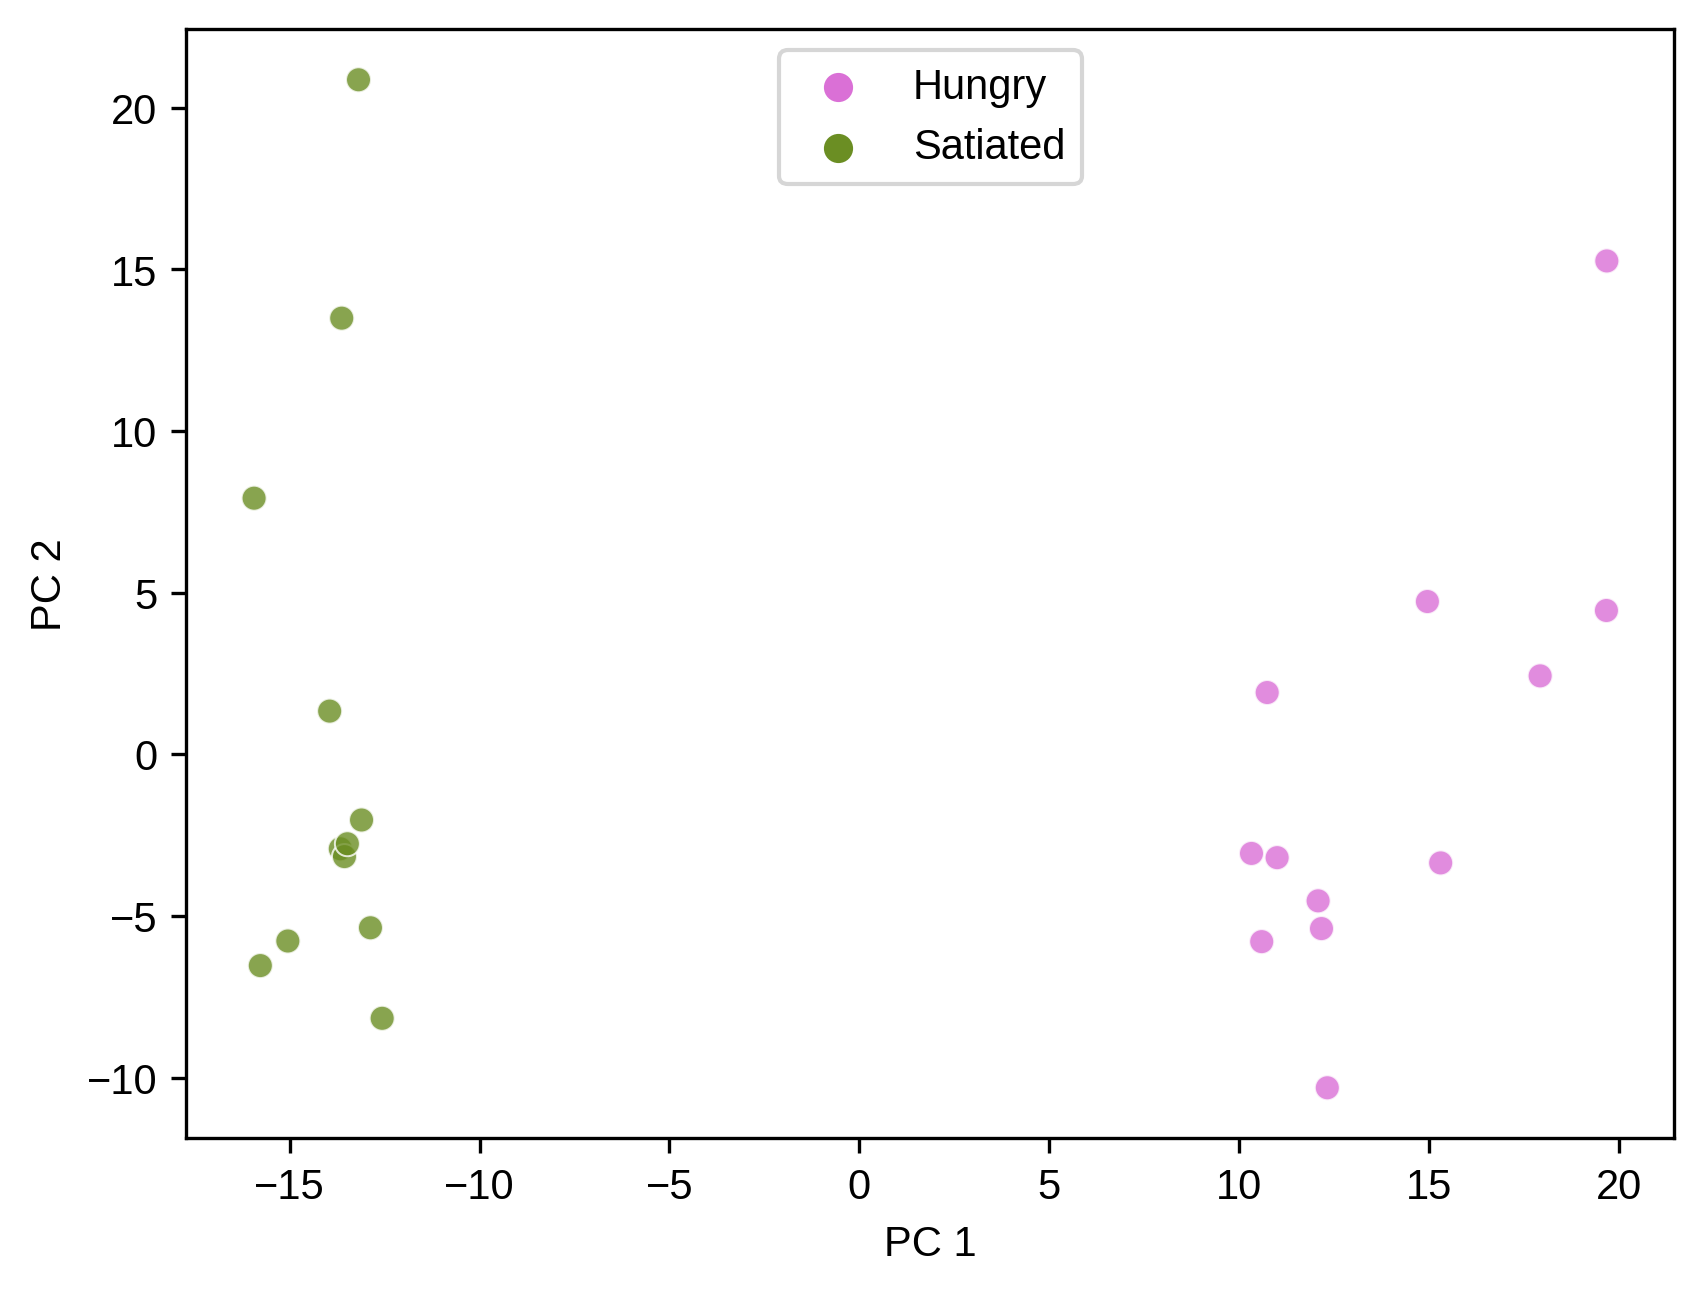

In [35]:
visualize_components(Xp[:, 0], Xp[:, 1], cues, colors)

## Trial-averaged data

In [40]:

hungry = trace_hungry.iloc[:,2:].to_numpy(dtype = float)
satiated = trace_satiated.iloc[:,2:].to_numpy(dtype = float)

TimeRange = 20
TotalBins = hungry.shape[1]

populationdata = np.concatenate([hungry,satiated],axis =1)


In [42]:
framerate = 1/0.3
pre_window_size = Bins_before # 6 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = TotalBins - Bins_before # 6 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + int((1.5*FR)/BinSize)] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 4 # Maximum colormap value. 
cmin = -4

trial_types = ['Hungry', 'Satiated']

/tmp/ipykernel_148346/4166298308.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


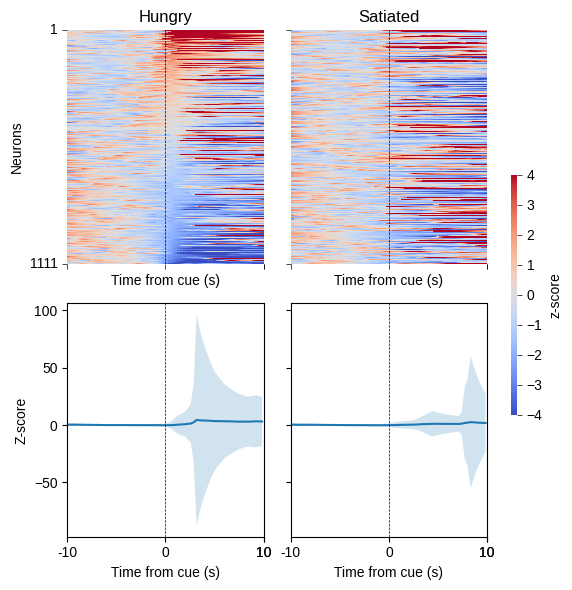

In [43]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([0, len(sortresponse)-1])
    ax.set_yticklabels(['1', str(len(sortresponse))])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int(round((a - pre_window_size) / framerate))) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int(round((a-pre_window_size+0.0)/framerate)))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Z-score')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

In [44]:
populationdata_centered = zscore(populationdata)

Number of PCs = 132
Number of PCs to keep = 10


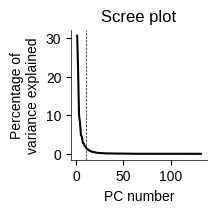

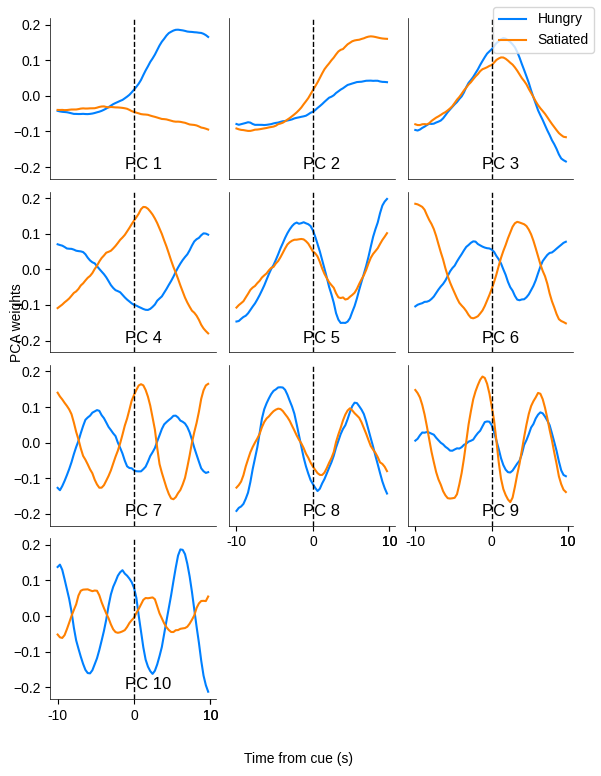

In [45]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata_centered.shape[1], whiten=True)
    pca.fit(populationdata_centered) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata_centered)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = np.argmin(xprime) #np.min(np.where(np.cumsum(x)>55))-1 #np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int(round((a - pre_window_size) / framerate)))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
fig.legend(trial_types,)
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

In [46]:
pca = PCA(n_components=10)
Xa_p = pca.fit_transform(populationdata_centered.T).T


In [47]:
trial_types = ['Hungry', 'Satiated']
trial_size = TotalBins
# time = 

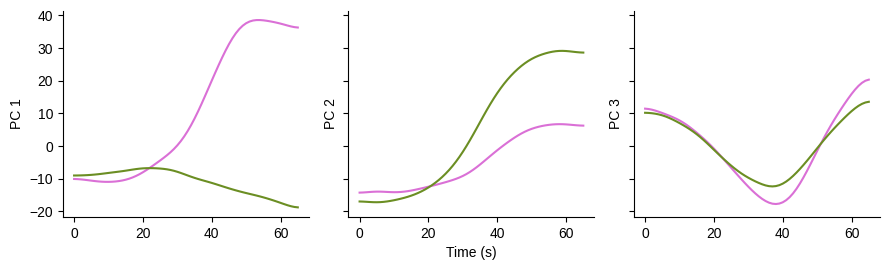

In [48]:
fig, axes = plt.subplots(1, 3, figsize=[10, 2.8], sharey='row')
for comp in range(3):
    ax = axes[comp]
    for kk, type in enumerate(trial_types):
        x = Xa_p[comp, kk * trial_size :(kk+1) * trial_size]
        x = gaussian_filter1d(x, sigma=3)
        ax.plot(x, c=colors[kk])
#     add_stim_to_plot(ax)
    ax.set_ylabel('PC {}'.format(comp+1))
# add_orientation_legend(axes[2])
axes[1].set_xlabel('Time (s)')
sns.despine(fig=fig, right=True, top=True)
plt.tight_layout(rect=[0, 0, 0.9, 1])

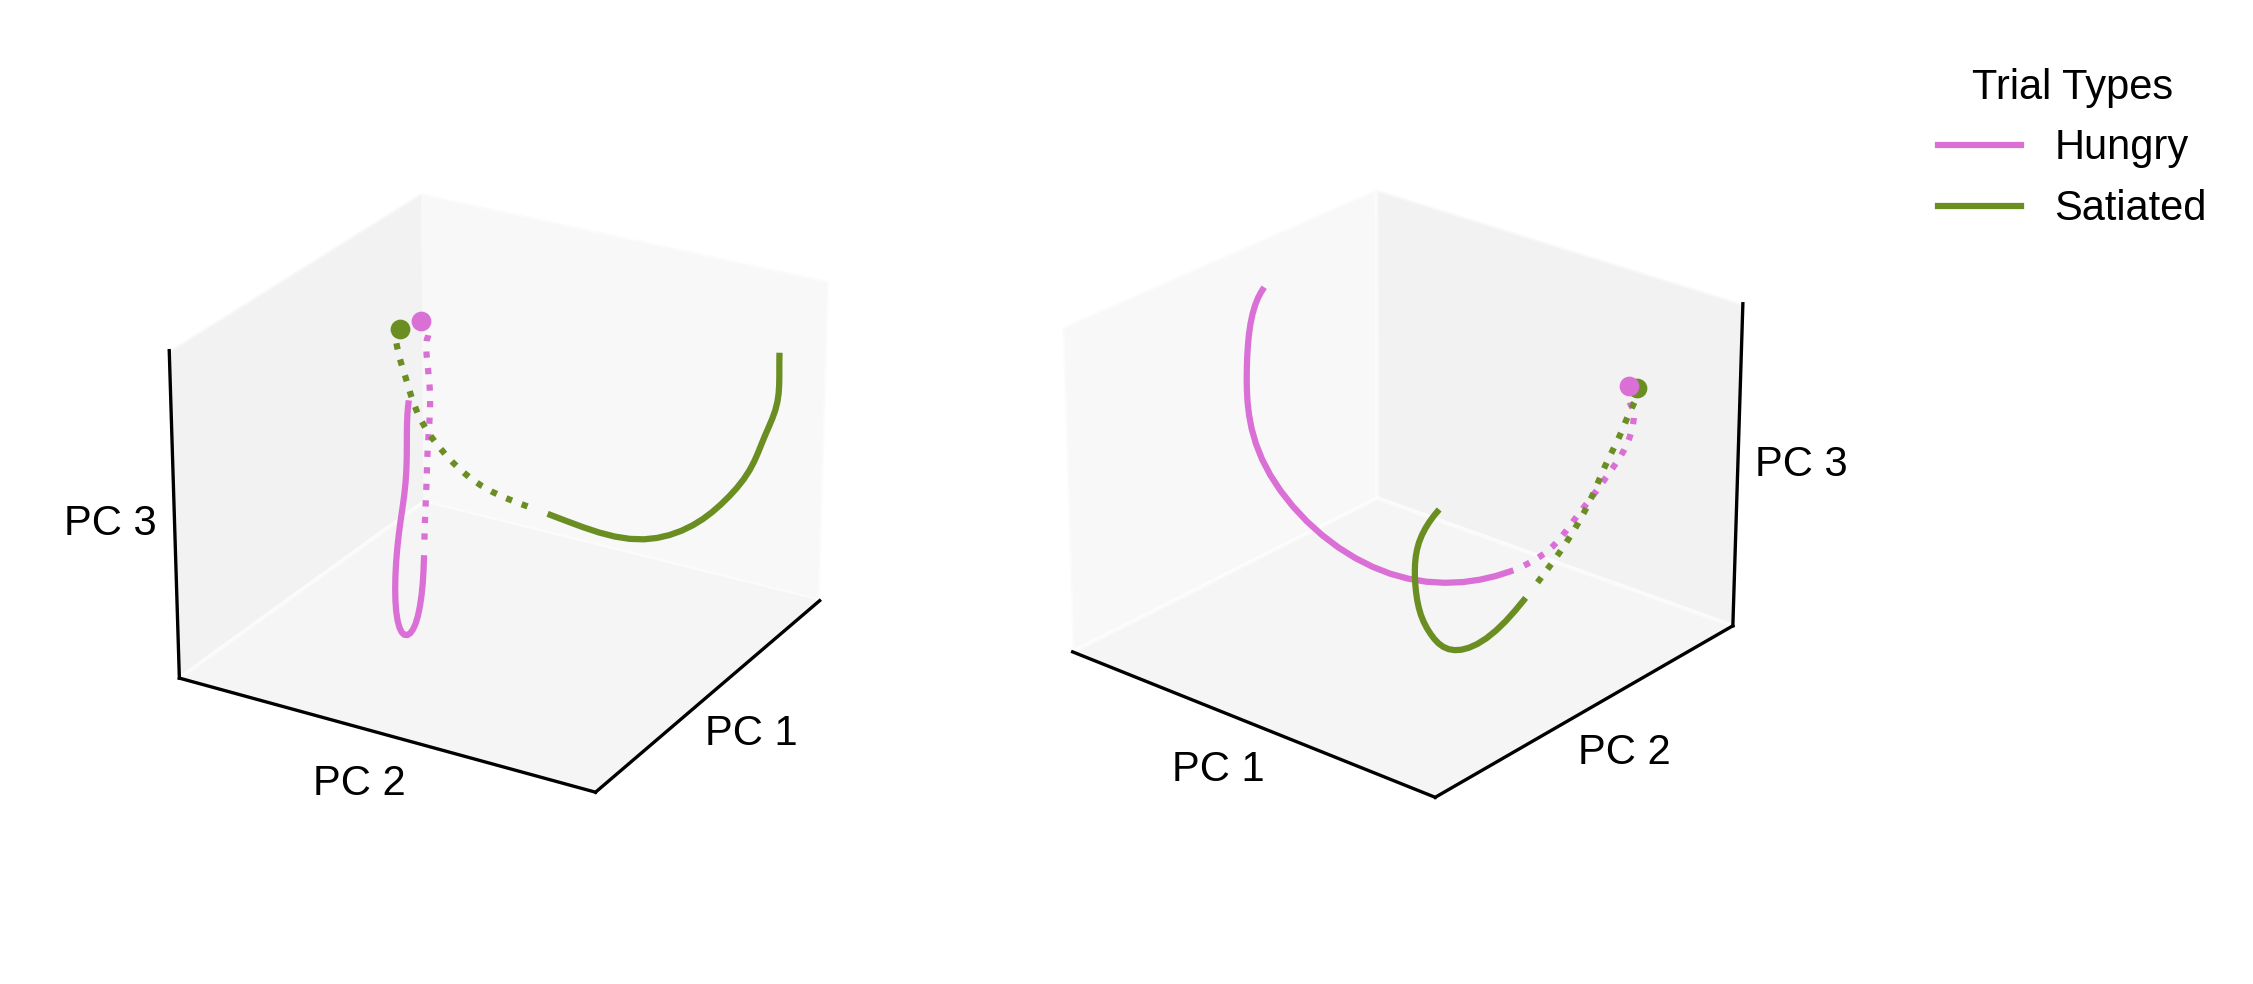

In [49]:

# pick the components corresponding to the x, y, and z axes
component_x = 0
component_y = 1
component_z = 2

# create a boolean mask so we can plot activity during stimulus as 
# solid line, and pre and post stimulus as a dashed line
stim_mask = ~np.logical_and(np.arange(trial_size) >= pre_window_size,
               np.arange(trial_size) < (trial_size))

# utility function to clean up and label the axes
def style_3d_ax(ax, labelpad=-10):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = True
    ax.zaxis.pane.fill = True
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xlabel('PC 1', labelpad=labelpad)
    ax.set_ylabel('PC 2', labelpad=labelpad)
    ax.set_zlabel('PC 3', labelpad=labelpad)
    ax.set_box_aspect(aspect=None, zoom=0.8)




sigma = 2 # smoothing amount

# set up a figure with two 3d subplots, so we can have two different views
fig = plt.figure(figsize=[10, 4], dpi = 300)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axs = [ax1, ax2]

for ax in axs:
    legend_labels = []  # List to store legend labels
    for t, t_type in enumerate(trial_types):

        # for every trial type, select the part of the component
        # which corresponds to that trial type:
        x = Xa_p[component_x, t * trial_size :(t+1) * trial_size]
        y = Xa_p[component_y, t * trial_size :(t+1) * trial_size]
        z = Xa_p[component_z, t * trial_size :(t+1) * trial_size]
        
        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)
        z = gaussian_filter1d(z, sigma=sigma)

        # use the mask to plot stimulus and pre/post stimulus separately
        z_stim = z.copy()
        z_stim[stim_mask] = np.nan
        z_prepost = z.copy()
        z_prepost[~stim_mask] = np.nan

        ax.plot(x, y, z_stim, c = colors[t], label=f'{t_type}')
        ax.plot(x, y, z_prepost, c=colors[t], ls=':')
        
        # plot dots at initial point
        ax.scatter(x[0], y[0], z[0], c=colors[t], s=14)
        
        # make the axes a bit cleaner
        style_3d_ax(ax)
        
ax2.legend(title="Trial Types", bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)

# specify the orientation of the 3d plot        
ax1.view_init(elev=25, azim=30)
ax2.view_init(elev=25, azim=130)
plt.subplots_adjust(left=0, wspace = -0.5)
# plt.tight_layout()
plt.show()

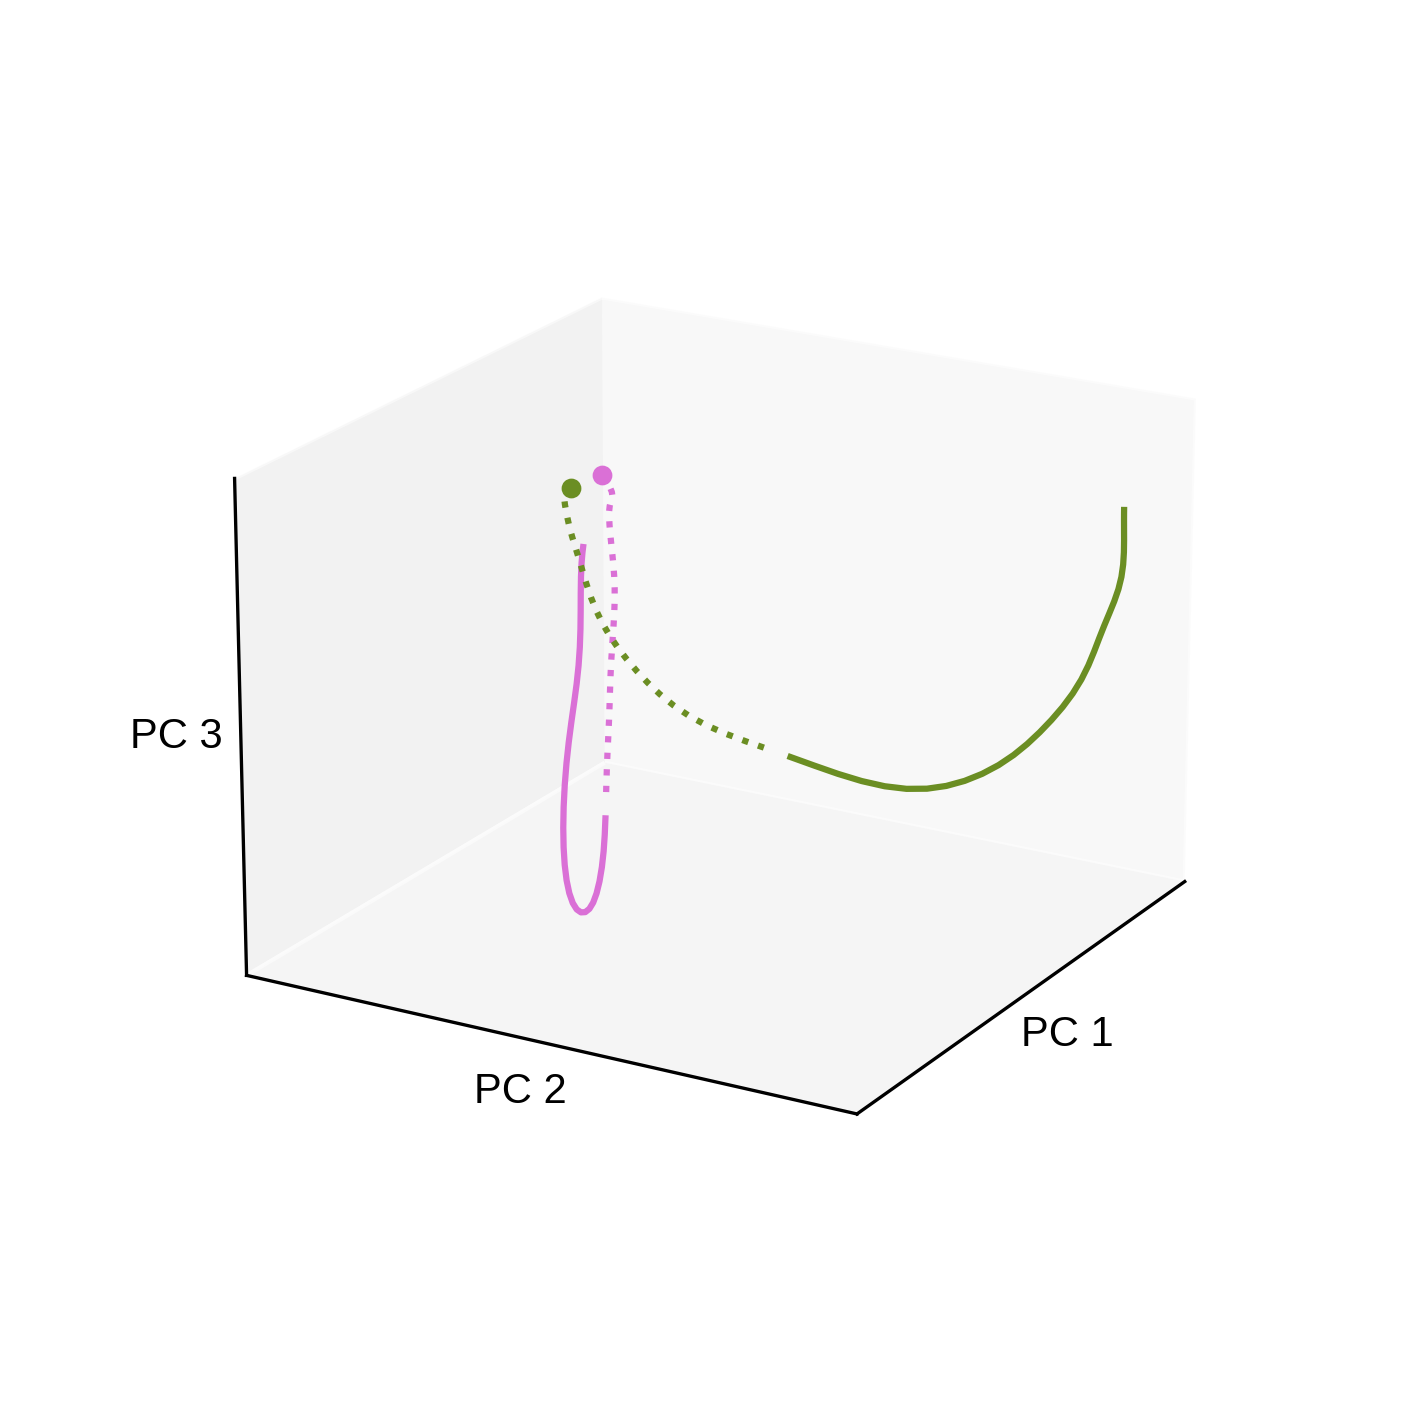

In [50]:
fig = plt.figure(dpi = 300)
ax = fig.add_subplot(projection='3d')

legend_labels = []  # List to store legend labels
for t, t_type in enumerate(trial_types):

    # for every trial type, select the part of the component
    # which corresponds to that trial type:
    x = Xa_p[component_x, t * trial_size :(t+1) * trial_size]
    y = Xa_p[component_y, t * trial_size :(t+1) * trial_size]
    z = Xa_p[component_z, t * trial_size :(t+1) * trial_size]

    # apply some smoothing to the trajectories
    x = gaussian_filter1d(x, sigma=sigma)
    y = gaussian_filter1d(y, sigma=sigma)
    z = gaussian_filter1d(z, sigma=sigma)

    # use the mask to plot stimulus and pre/post stimulus separately
    z_stim = z.copy()
    z_stim[stim_mask] = np.nan
    z_prepost = z.copy()
    z_prepost[~stim_mask] = np.nan

    ax.plot(x, y, z_stim, c = colors[t], label=f'{t_type}')
    ax.plot(x, y, z_prepost, c=colors[t], ls=':')

    # plot dots at initial point
    ax.scatter(x[0], y[0], z[0], c=colors[t], s=14)



    # make the axes a bit cleaner
    style_3d_ax(ax)
    
# specify the orientation of the 3d plot        
ax.view_init(elev=20, azim=30)
plt.tight_layout()
plt.show()

## Trial-average-concatenate pca hybrid

In [83]:
pca = PCA(n_components=10)
pca.fit(populationdata_centered.T)


PCA(n_components=10)

In [84]:
traceconcat_trial = pd.concat([trace_hungry_trial.iloc[:, 2:], trace_satiated_trial.iloc[:, 2:]], axis = 1, ignore_index = True)
traceconcat_trial = traceconcat_trial.to_numpy(dtype = "float64")

In [85]:
traceconcat_trial

array([[-0.72024589, -0.73461274, -0.74729616, ...,  0.85336456,
         0.92180552,  1.07004428],
       [ 0.68986404,  0.61046921,  0.54126374, ..., -0.08825347,
        -0.12056102, -0.15361425],
       [ 0.22579348,  0.21493709,  0.2050302 , ..., -0.32260937,
        -0.32670238, -0.33108588],
       ...,
       [-0.1014342 , -0.1014342 , -0.1014342 , ..., -0.1014342 ,
        -0.1014342 , -0.1014342 ],
       [ 2.82457069,  2.37516961,  2.02203565, ..., -0.12568789,
        -0.12568789, -0.12568789],
       [-0.11003815, -0.11003815, -0.11003815, ...,  3.01527174,
         2.68198025,  2.36137475]])

In [86]:
traceconcat_trial.shape

(1111, 1584)

In [87]:
trial_number

12

In [88]:
trials = [traceconcat_trial[:, i*trial_size:(i+1)*trial_size] for i in range(trial_number*2)]
trials

[array([[-0.72024589, -0.73461274, -0.74729616, ..., -1.01936296,
         -1.02027589, -1.02122182],
        [ 0.68986404,  0.61046921,  0.54126374, ...,  0.72303562,
          1.07426393,  0.97305955],
        [ 0.22579348,  0.21493709,  0.2050302 , ...,  0.07924859,
          0.07080925,  0.06177096],
        ...,
        [-0.1014342 , -0.1014342 , -0.1014342 , ..., -0.1014342 ,
         -0.1014342 , -0.1014342 ],
        [ 2.82457069,  2.37516961,  2.02203565, ..., -0.12505403,
         -0.12514353, -0.12522613],
        [-0.11003815, -0.11003815, -0.11003815, ..., -0.11003815,
         -0.11003815, -0.11003815]]),
 array([[-1.03439984, -1.03471511, -1.03499345, ..., -0.84857438,
         -0.85654705, -0.86480792],
        [-0.18258826, -0.21214676, -0.23791179, ...,  0.15438025,
          0.10925978,  0.06309789],
        [ 0.34269151,  0.33046586,  0.31930946, ...,  0.3026494 ,
          0.29179385,  0.28016786],
        ...,
        [-0.1014342 , -0.1014342 , -0.1014342 , ..., -

In [89]:
print('Number of trials: {}'.format(len(trials)))
print('Types of trials (orientations): {}'.format(trial_types)) 
print('Dimensions of single trial array (# neurons by # time points): {}'.format(trials[0].shape))
print('Trial types (orientations): {}'.format(trial_types))


Number of trials: 24
Types of trials (orientations): ['Hungry', 'Satiated']
Dimensions of single trial array (# neurons by # time points): (1111, 66)
Trial types (orientations): ['Hungry', 'Satiated']


In [90]:
projected_trials = []
for trial in trials:
    # scale every trial using the same scaling applied to the averages 
    trial = zscore(trial)
    # project every trial using the pca fit on averages
    proj_trial = pca.transform(trial.T).T
    projected_trials.append(proj_trial)

In [91]:
trial_types = ['Hungry', 'Satiated']
trial_size = Bins
trial_number = 12

In [92]:
trial_type = np.concatenate([np.repeat(trial_types[i], trial_number) for i in range(len(trial_types))])
trial_type

array(['Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry',
       'Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry',
       'Satiated', 'Satiated', 'Satiated', 'Satiated', 'Satiated',
       'Satiated', 'Satiated', 'Satiated', 'Satiated', 'Satiated',
       'Satiated', 'Satiated'], dtype='<U8')

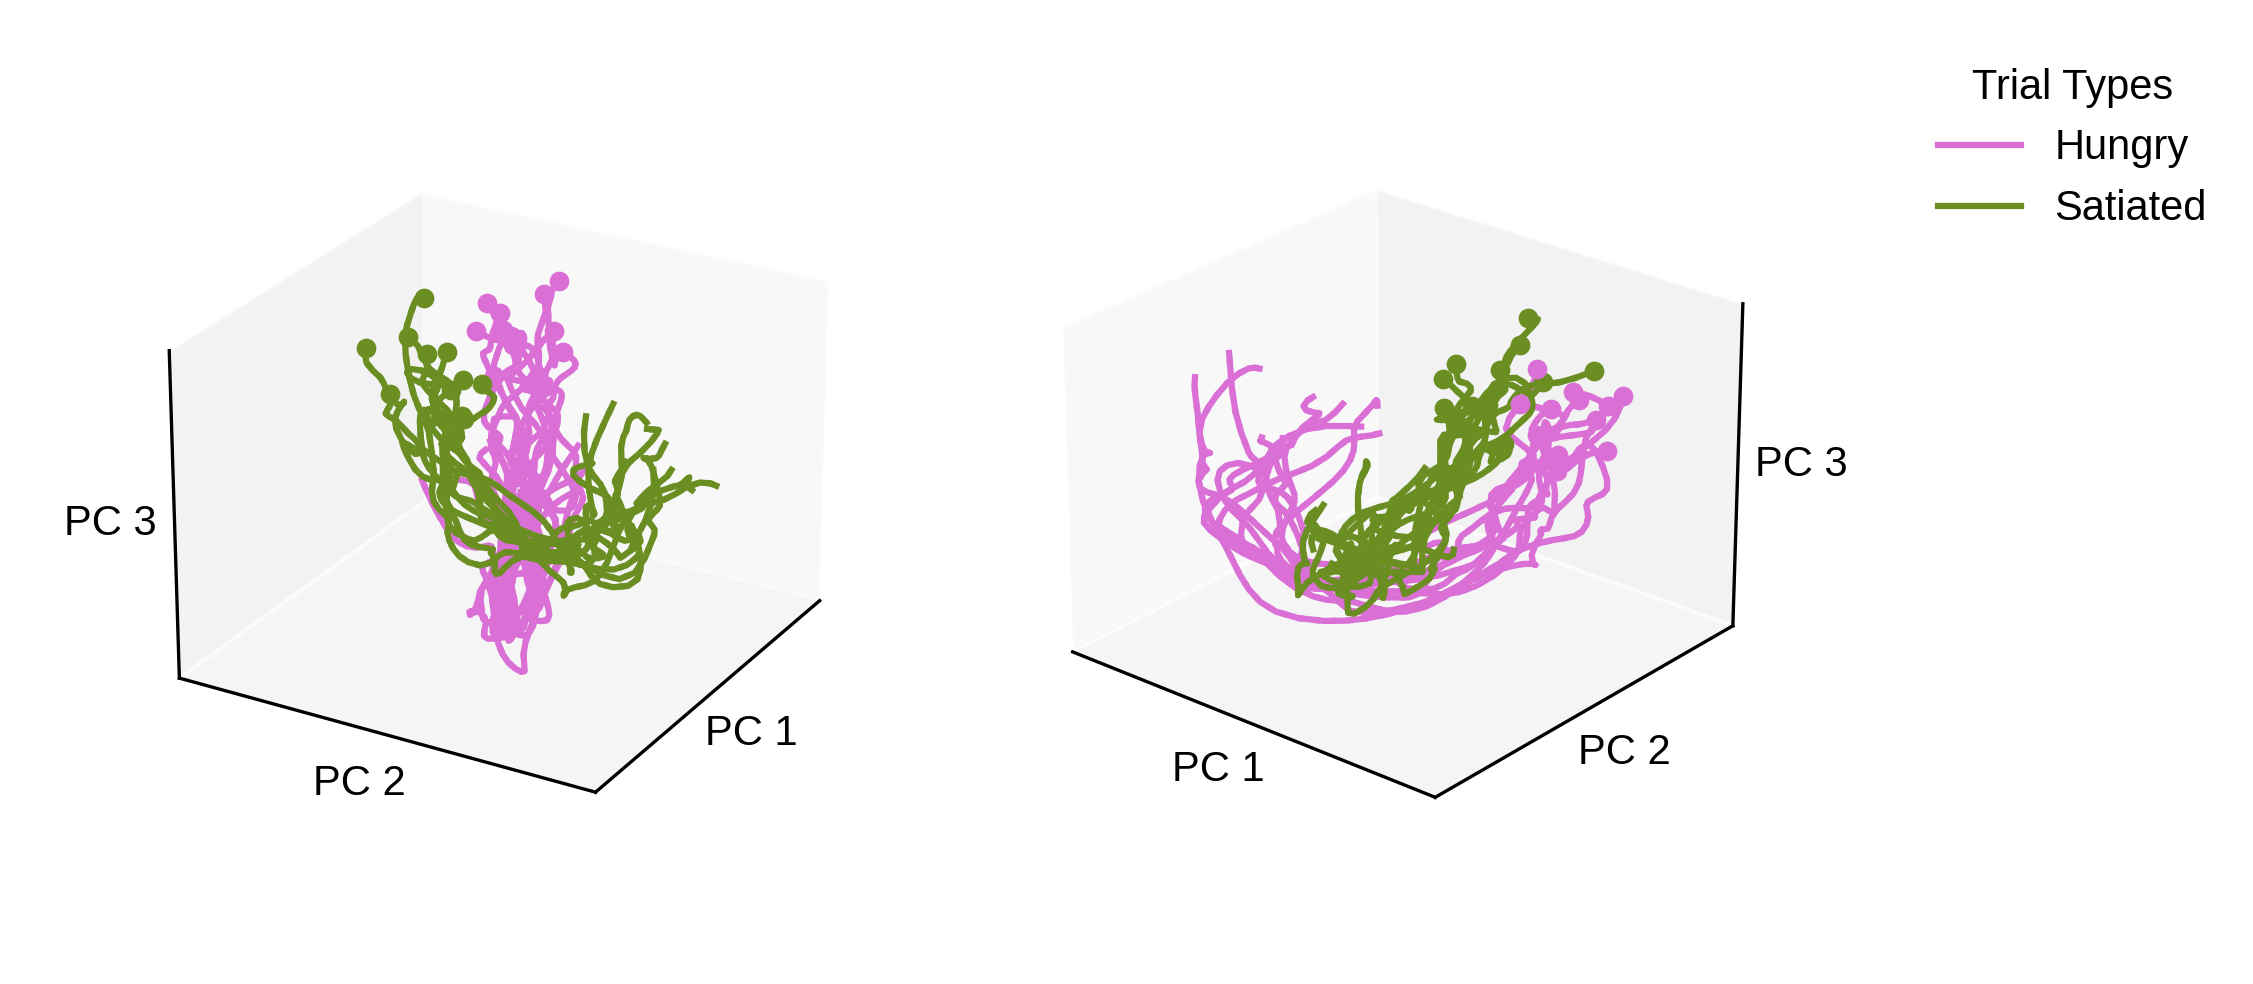

In [93]:
# pick the components corresponding to the x, y, and z axes
component_x = 0
component_y = 1
component_z = 2

# create a boolean mask so we can plot activity during stimulus as 
# solid line, and pre and post stimulus as a dashed line
stim_mask = ~np.logical_and(np.arange(trial_size) >= pre_window_size,
               np.arange(trial_size) < (trial_size))

# utility function to clean up and label the axes
def style_3d_ax(ax, labelpad=-10):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = True
    ax.zaxis.pane.fill = True
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xlabel('PC 1', labelpad=labelpad)
    ax.set_ylabel('PC 2', labelpad=labelpad)
    ax.set_zlabel('PC 3', labelpad=labelpad)
    ax.set_box_aspect(aspect=None, zoom=0.8)


colors_type = {'Hungry': 'orchid', 'Satiated': 'olivedrab'}

sigma = 1 # smoothing amount

# set up a figure with two 3d subplots, so we can have two different views
fig = plt.figure(figsize=[10, 4], dpi = 300)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axs = [ax1, ax2]

for ax in axs:
    legend_labels = []  # List to store legend labels
    for t, (trial, t_type) in enumerate(zip(projected_trials, trial_type)):
            
        x = trial[component_x, :]
        y = trial[component_y, :]
        z = trial[component_z, :]

        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)
        z = gaussian_filter1d(z, sigma=sigma)

        # use the mask to plot stimulus and pre/post stimulus separately
        z_stim = z.copy()
#         z_stim[stim_mask] = np.nan
        z_prepost = z.copy()
#         z_prepost[~stim_mask] = np.nan

        ax.plot(x, y, z_stim, c = colors_type[t_type], label= f'{t_type}' if (t == 0) or (t == trial_number) else None)
        ax.plot(x, y, z_prepost, c= colors_type[t_type], ls=':')

        # plot dots at initial point
        ax.scatter(x[0], y[0], z[0], c=colors_type[t_type], s=14)
        
        # make the axes a bit cleaner
        style_3d_ax(ax)
        
ax2.legend(title="Trial Types", bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)

# specify the orientation of the 3d plot        
ax1.view_init(elev=25, azim=30)
ax2.view_init(elev=25, azim=130)
plt.subplots_adjust(left=0, wspace = -0.5)
# plt.tight_layout()
plt.show()

/tmp/ipykernel_148346/897635483.py:75: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[0], y[0], z[0], c=trial_color, s=14)


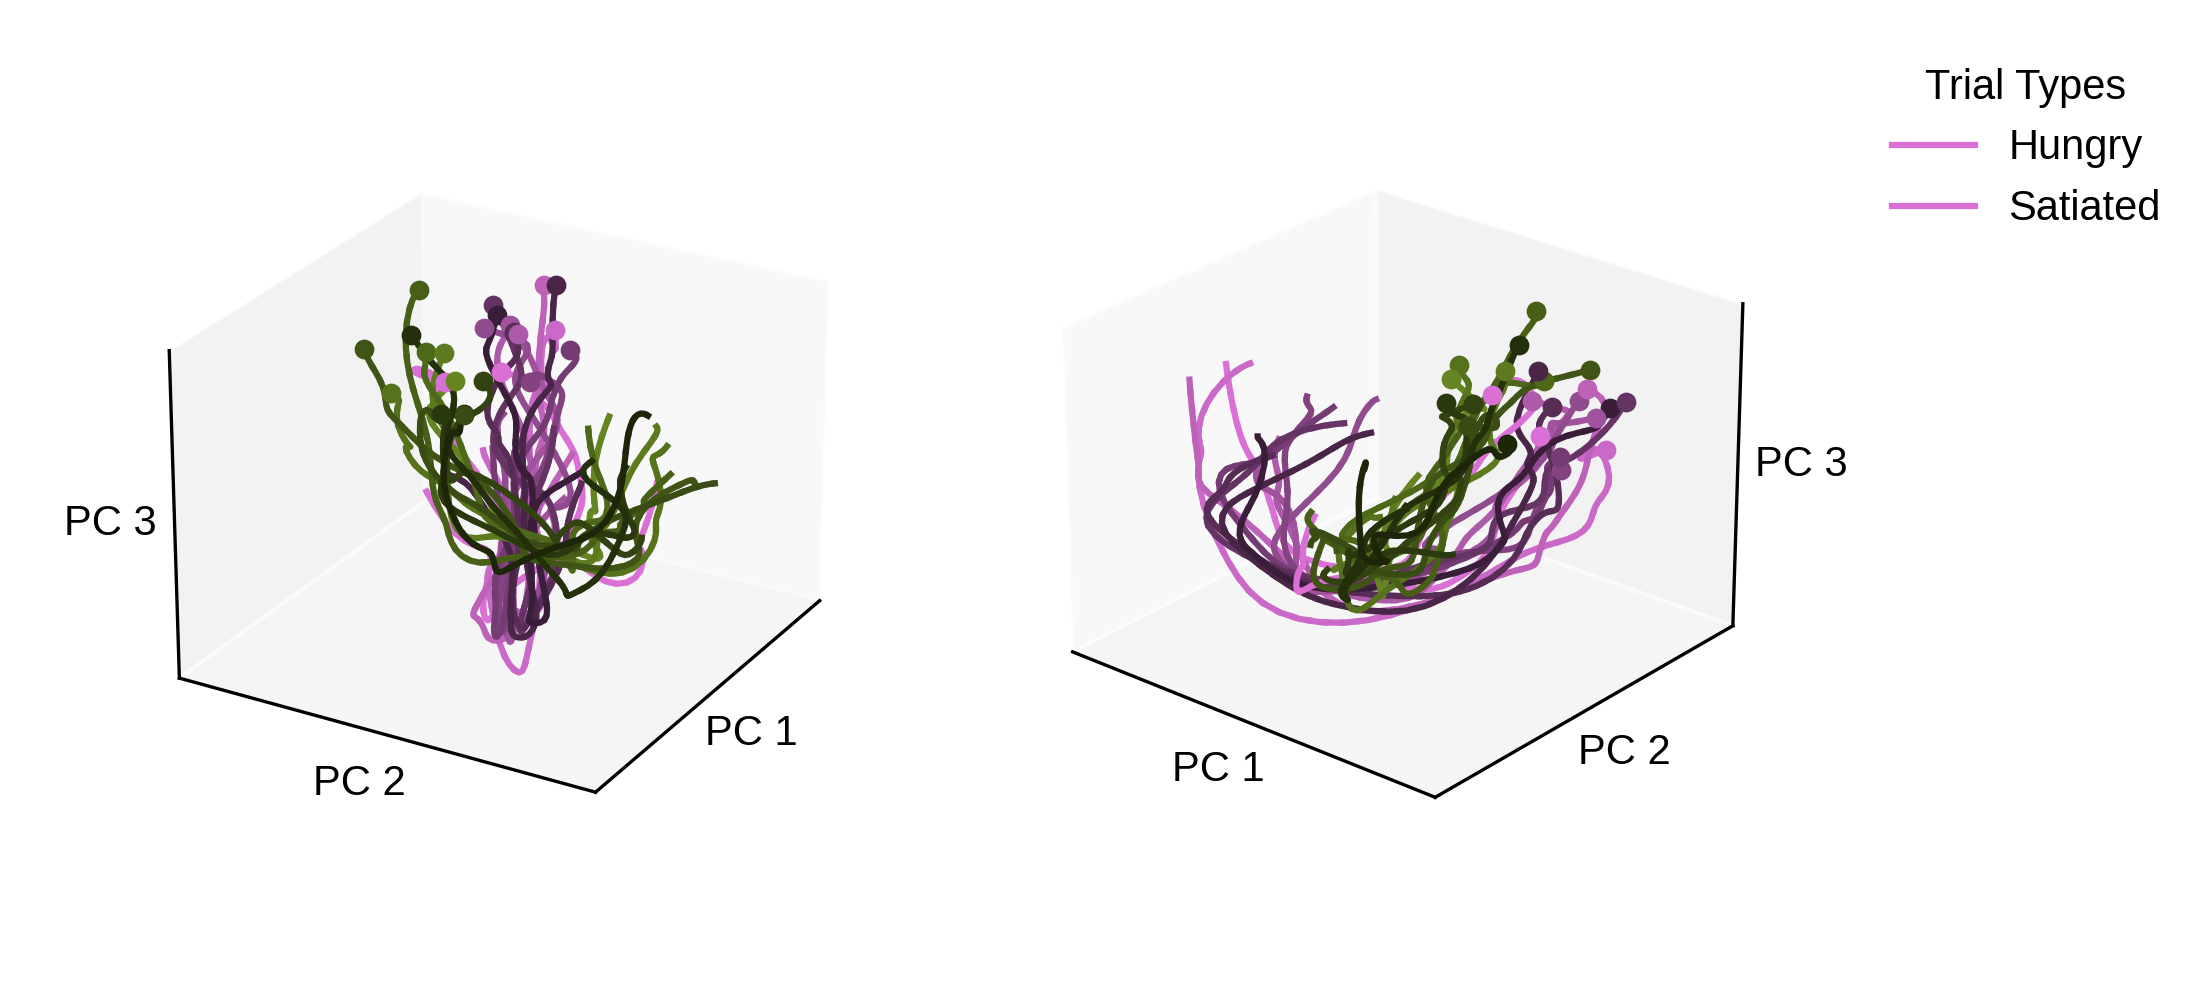

In [94]:

# pick the components corresponding to the x, y, and z axes
component_x = 0
component_y = 1
component_z = 2

# create a boolean mask so we can plot activity during stimulus as 
# solid line, and pre and post stimulus as a dashed line
stim_mask = ~np.logical_and(np.arange(trial_size) >= pre_window_size,
               np.arange(trial_size) < (trial_size))

# Convert colors to RGBA if they aren't already
rgba_colors = [mpl.colors.to_rgba(c) for c in colors]

# Define a function to create darker shades of a color
def get_darker_shade(rgba_color, shade_factor):
    # Apply the shade_factor to the RGB channels, not the alpha channel
    return (rgba_color[0] * shade_factor, rgba_color[1] * shade_factor, rgba_color[2] * shade_factor, rgba_color[3])

# utility function to clean up and label the axes
def style_3d_ax(ax, labelpad=-10):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = True
    ax.zaxis.pane.fill = True
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xlabel('PC 1', labelpad=labelpad)
    ax.set_ylabel('PC 2', labelpad=labelpad)
    ax.set_zlabel('PC 3', labelpad=labelpad)
    ax.set_box_aspect(aspect=None, zoom=0.8)




sigma = 2 # smoothing amount

# set up a figure with two 3d subplots, so we can have two different views
fig = plt.figure(figsize=[10, 4], dpi = 300)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axs = [ax1, ax2]

for ax in axs:
    legend_labels = []  # List to store legend labels
    for t, (trial, t_type) in enumerate(zip(projected_trials, trial_type)):
        base_rgba_color = rgba_colors[int((t-12)>0)]
        if t < 12:            
            shade_factor = 1 - (t / float(trial_number)) * 0.8  # Example to darken by up to 50%
        else:
            shade_factor = 1 - ((t-12) / float(trial_number)) * 0.8  # Example to darken by up to 50%
        trial_color = get_darker_shade(base_rgba_color, shade_factor)
    
        x = trial[component_x, :]
        y = trial[component_y, :]
        z = trial[component_z, :]

        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)
        z = gaussian_filter1d(z, sigma=sigma)

        # use the mask to plot stimulus and pre/post stimulus separately
        z_stim = z.copy()
#         z_stim[stim_mask] = np.nan
        z_prepost = z.copy()
#         z_prepost[~stim_mask] = np.nan

        ax.plot(x, y, z_stim, c = trial_color, label= f'{t_type}' if (t == 0) or (t == trial_number) else None)
        ax.plot(x, y, z_prepost, c= trial_color, ls=':')

        # plot dots at initial point
        ax.scatter(x[0], y[0], z[0], c=trial_color, s=14)
        
        # make the axes a bit cleaner
        style_3d_ax(ax)
        
   
        
ax2.legend(title="Trial Types", bbox_to_anchor=(1, 1), loc='upper left', frameon = False)

# specify the orientation of the 3d plot        
ax1.view_init(elev=25, azim=30)
ax2.view_init(elev=25, azim=130)
plt.subplots_adjust(left=0, wspace = -0.5)
# plt.tight_layout()
plt.show()

/tmp/ipykernel_148346/266140259.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_smooth[0], y_smooth[0], c=trial_color, s=6)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


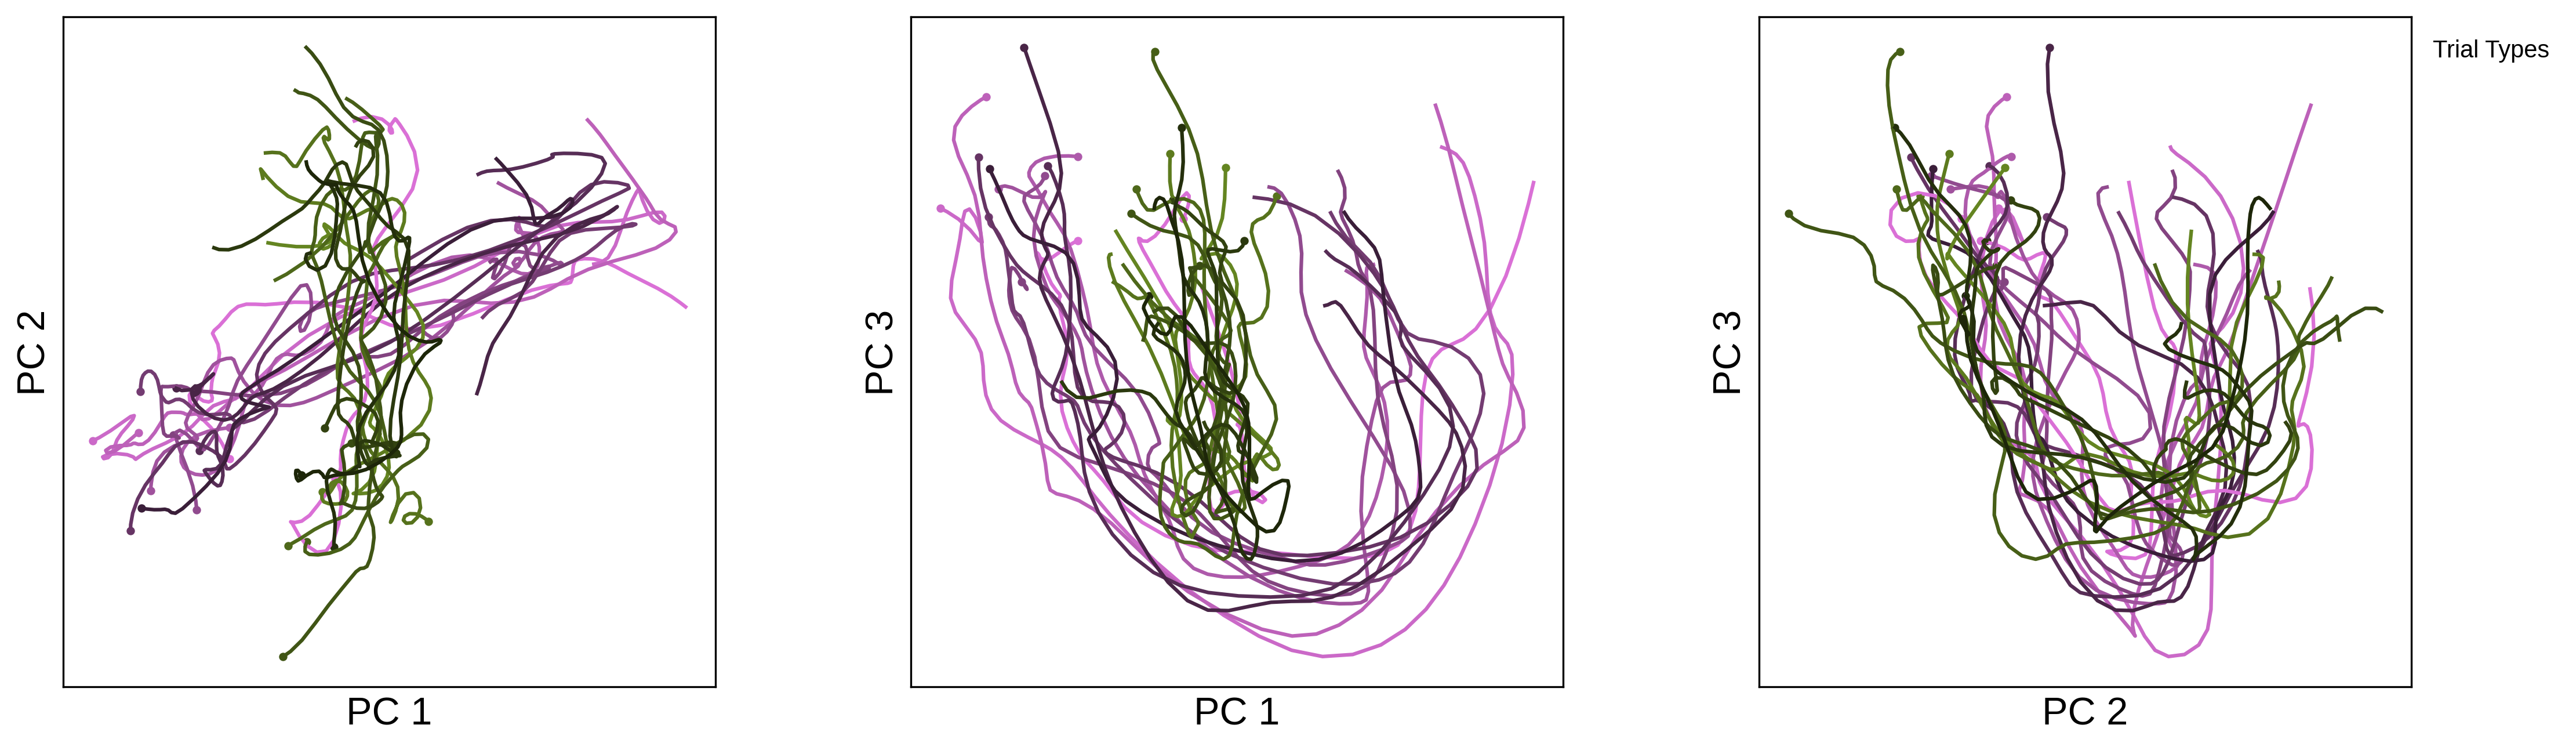

In [95]:


sigma = 1  # Smoothing amount

# Set up a figure with three 2D subplots for the different combinations of PCs
fig, axs = plt.subplots(1, 3, figsize=[15, 5], dpi=300)

# PC combinations to plot
pc_combinations = [(component_x, component_y), (component_x, component_z), (component_y, component_z)]

for ax, (pc1, pc2) in zip(axs, pc_combinations):
    legend_labels = []  # List to store legend labels
    for t, (trial, t_type) in enumerate(zip(projected_trials, trial_type)):
        base_rgba_color = rgba_colors[int((t-12)>0)]
        if t < 12:            
            shade_factor = 1 - (t / float(trial_number)) * 0.8  # Example to darken by up to 50%
        else:
            shade_factor = 1 - ((t-12) / float(trial_number)) * 0.8  # Example to darken by up to 50%
        trial_color = get_darker_shade(base_rgba_color, shade_factor)
    
        x = trial[pc1, :]
        y = trial[pc2, :]

        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)

         # Apply smoothing
        x_smooth = gaussian_filter1d(x, sigma=sigma)
        y_smooth = gaussian_filter1d(y, sigma=sigma)

        # Plotting
        ax.plot(x_smooth, y_smooth, c=trial_color, label=f'{t_type}' if i == 0 else None)
        ax.scatter(x_smooth[0], y_smooth[0], c=trial_color, s=6)


    # Style the axes (you may need to modify the style_3d_ax function for 2D plots or create a new styling function)
    style_2d_ax(ax)

# Adjusting subplot parameters and adding legend
plt.subplots_adjust(left=0, wspace=0.3)
axs[-1].legend(title="Trial Types", bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.show()


/tmp/ipykernel_148346/3704247503.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[0], y[0], z[0], c=trial_color, s=14)


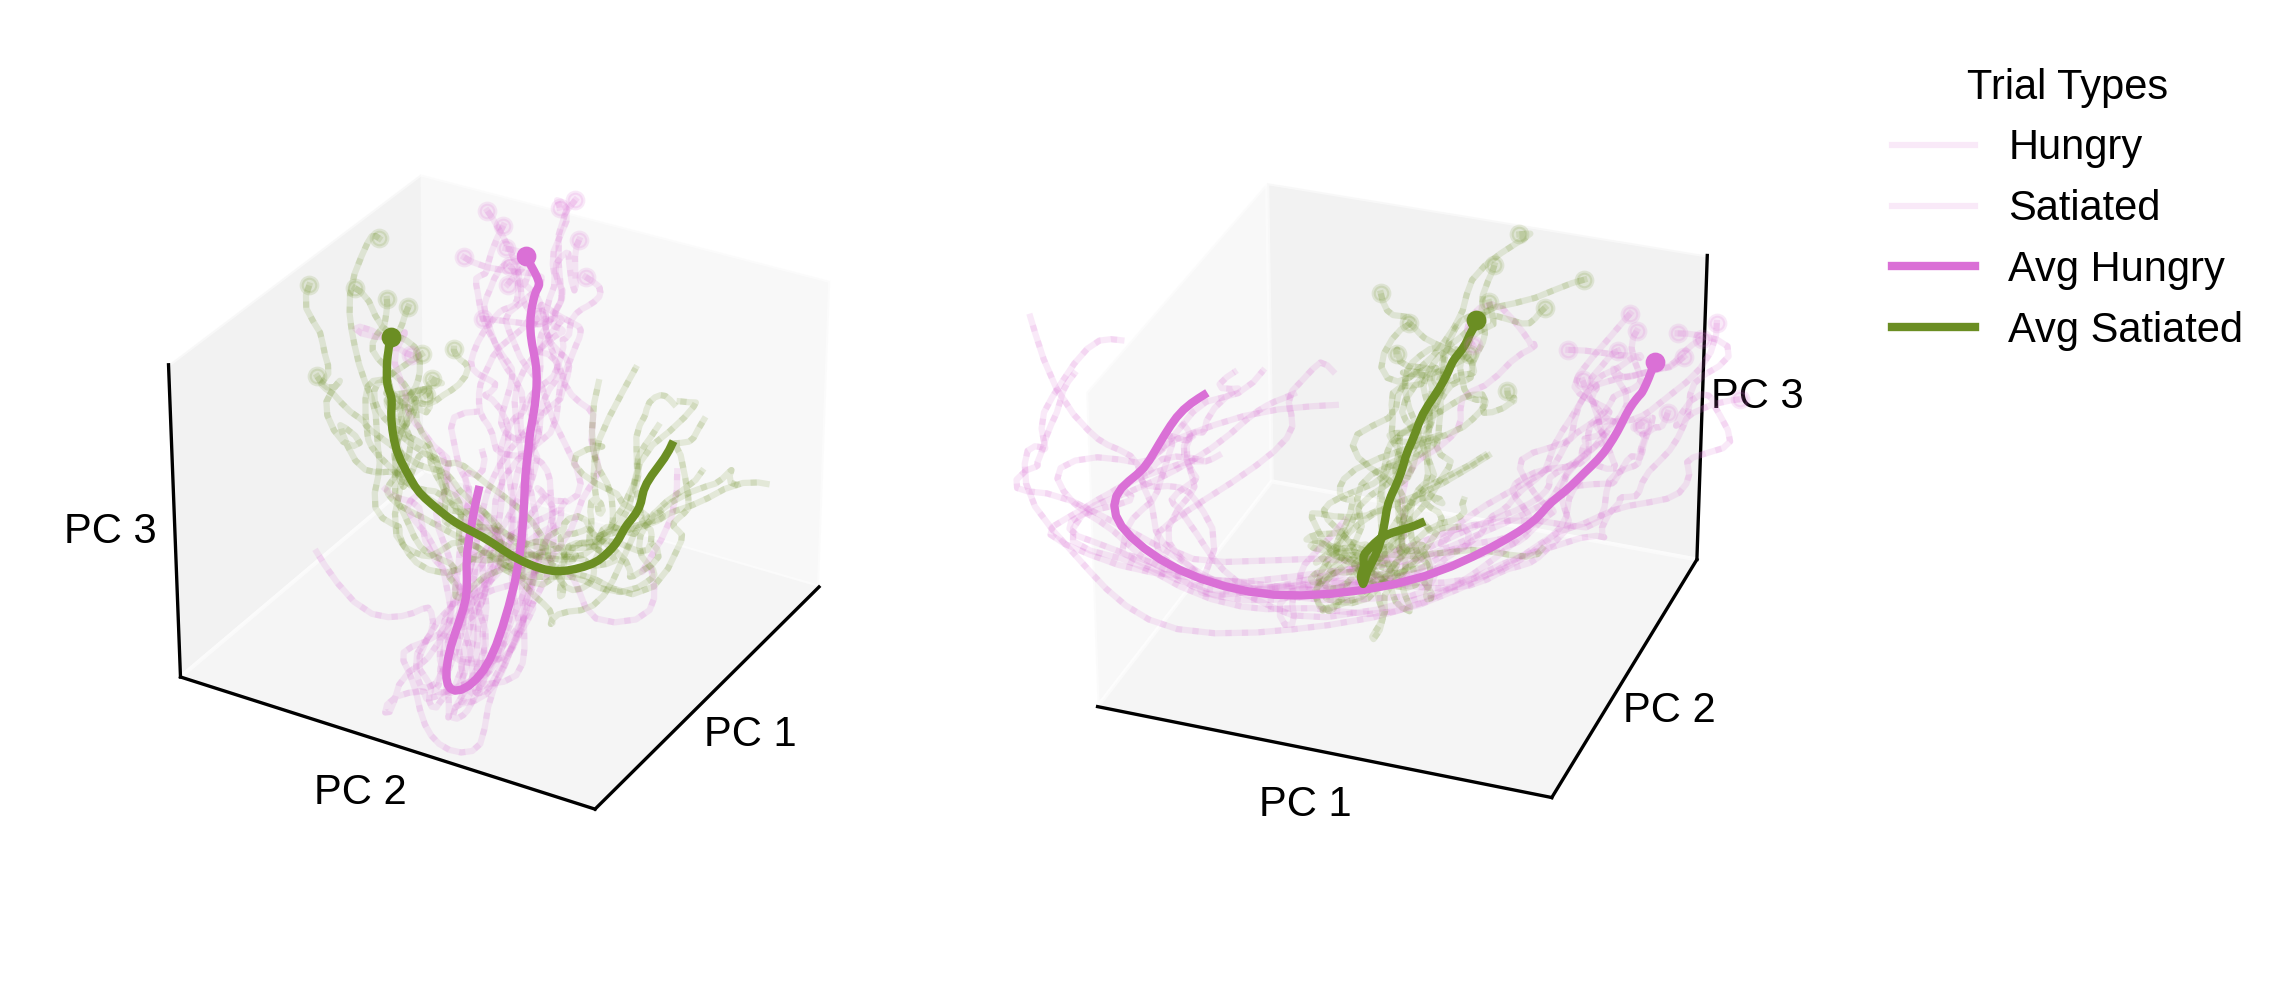

In [96]:

# Set up a figure with two 3d subplots, so we can have two different views
fig = plt.figure(figsize=[10, 4], dpi=300)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axs = [ax1, ax2]
sigma = 1

# Store the data for averaging
average_data = {t_type: {'x': [], 'y': [], 'z': []} for t_type in trial_types}

for ax in axs:
    for t, (trial, t_type) in enumerate(zip(projected_trials, trial_type)):
        base_rgba_color =  rgba_colors[int((t-12)>0)]

        if t < 12:            
            shade_factor = 1 - (t / float(trial_number)) * 0  # Example to darken by up to 50%
        else:
            shade_factor = 1 - ((t-12) / float(trial_number)) * 0  # Example to darken by up to 50%
        trial_color = get_darker_shade(base_rgba_color, shade_factor)
        trial_color = trial_color[:3] + (0.15,)

        x = trial[component_x, :]
        y = trial[component_y, :]
        z = trial[component_z, :]

        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)
        z = gaussian_filter1d(z, sigma=sigma)

        # use the mask to plot stimulus and pre/post stimulus separately
        z_stim = z.copy()
#         z_stim[stim_mask] = np.nan
        z_prepost = z.copy()
#         z_prepost[~stim_mask] = np.nan

        ax.plot(x, y, z_stim, c = trial_color, label= f'{t_type}' if (t == 0) or (t == trial_number) else None)
        ax.plot(x, y, z_prepost, c= trial_color, ls=':')

        # plot dots at initial point
        ax.scatter(x[0], y[0], z[0], c=trial_color, s=14)


        # Accumulate data for averaging
        average_data[t_type]['x'].append(x)
        average_data[t_type]['y'].append(y)
        average_data[t_type]['z'].append(z)
    
    for t_type in trial_types:

        # Calculate and plot the average trace for each trial type
        avg_x = np.mean(average_data[t_type]['x'], axis=0)
        avg_y = np.mean(average_data[t_type]['y'], axis=0)
        avg_z = np.mean(average_data[t_type]['z'], axis=0)

        # Apply smoothing
        avg_x_smooth = gaussian_filter1d(avg_x, sigma=sigma)
        avg_y_smooth = gaussian_filter1d(avg_y, sigma=sigma)
        avg_z_smooth = gaussian_filter1d(avg_z, sigma=sigma)

        # Plotting the average trace
        ax.plot(avg_x_smooth, avg_y_smooth, avg_z_smooth, c=colors_type[t_type], linewidth=2, label=f'Avg {t_type}')
        ax.scatter(avg_x_smooth[0], avg_y_smooth[0], avg_z_smooth[0], c=colors_type[t_type], s=14)

    # Style the axes
    style_3d_ax(ax)

# Adding legend and final adjustments
ax2.legend(title="Trial Types", bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
ax1.view_init(elev=30, azim=30)
ax2.view_init(elev=30, azim=110)
ax1.set_ylim(-8, 8)
ax1.set_xlim(-8, 8)
ax1.set_zlim(-8, 8)
ax2.set_ylim(-8, 8)
ax2.set_xlim(-8, 8)
ax2.set_zlim(-8, 8)
plt.subplots_adjust(left=0, wspace=-0.5)
plt.show()




/tmp/ipykernel_148346/3805719921.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_smooth[0], y_smooth[0], c=trial_color, s=10)


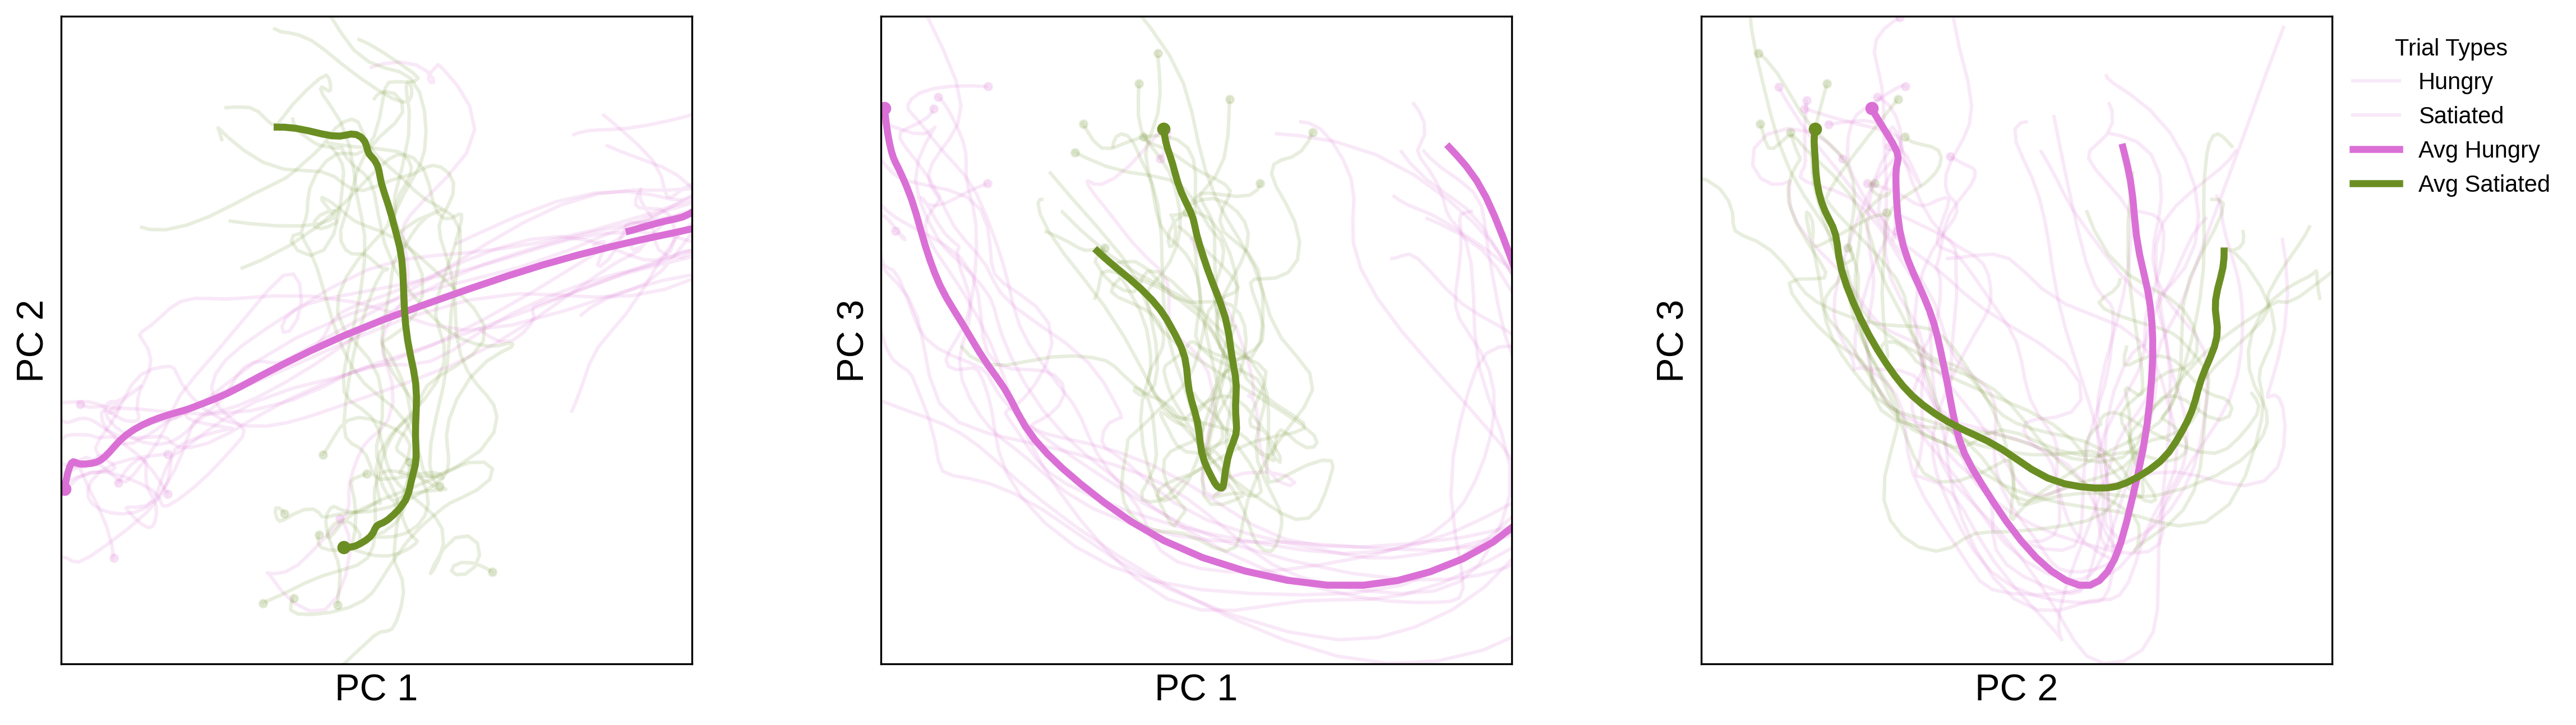

In [97]:
sigma = 1  # Smoothing amount

# Set up a figure with three 2D subplots for the different combinations of PCs
fig, axs = plt.subplots(1, 3, figsize=[15, 5], dpi=300)

# PC combinations to plot
pc_combinations = [(component_x, component_y), (component_x, component_z), (component_y, component_z)]

for ax, (pc1, pc2) in zip(axs, pc_combinations):
    average_data = {t_type: {'x': [], 'y': []} for t_type in trial_types}

    for t, (trial, t_type) in enumerate(zip(projected_trials, trial_type)):
        base_rgba_color = rgba_colors[int((t-12)>0)]
        if t < 12:            
            shade_factor = 1 - (t / float(trial_number)) * 0  # Example to darken by up to 50%
        else:
            shade_factor = 1 - ((t-12) / float(trial_number)) * 0  # Example to darken by up to 50%
        trial_color = get_darker_shade(base_rgba_color, shade_factor)
        trial_color = trial_color[:3] + (0.15,)
    
        x = trial[pc1, :]
        y = trial[pc2, :]

        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)

         # Apply smoothing
        x_smooth = gaussian_filter1d(x, sigma=sigma)
        y_smooth = gaussian_filter1d(y, sigma=sigma)

        # Plotting
        ax.plot(x_smooth, y_smooth, c=trial_color, label=f'{t_type}' if (t == 0) or (t == trial_number) else None)
        ax.scatter(x_smooth[0], y_smooth[0], c=trial_color, s=10)
                    
        # Accumulate data for averaging
        average_data[t_type]['x'].append(x)
        average_data[t_type]['y'].append(y)
        
    for t_type in trial_types:
        
        # Calculate and plot the average trace for each trial type
        avg_x = np.mean(average_data[t_type]['x'], axis=0)
        avg_y = np.mean(average_data[t_type]['y'], axis=0)

        # Apply smoothing
        avg_x_smooth = gaussian_filter1d(avg_x, sigma=sigma)
        avg_y_smooth = gaussian_filter1d(avg_y, sigma=sigma)

        # Plotting the average trace
        ax.plot(avg_x_smooth, avg_y_smooth, c=colors_type[t_type], linewidth=3, label=f'Avg {t_type}')
        ax.scatter(avg_x_smooth[0], avg_y_smooth[0], c=colors_type[t_type], s=22)

    # Style the axes (you may need to modify the style_3d_ax function for 2D plots or create a new styling function)
    style_2d_ax(ax)
    ax.set_ylim(-8, 8)
    ax.set_xlim(-8, 8)


# Adjusting subplot parameters and adding legend
plt.subplots_adjust(left=0, wspace=0.3)
axs[-1].legend(title="Trial Types", bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.show()

## Trial-average-concatenate-zscore pca hybrid

In [98]:
pca = PCA(n_components=10)
pca.fit(populationdata_centered.T)


PCA(n_components=10)

In [99]:
pca.explained_variance_ratio_

array([0.30590397, 0.21472177, 0.0996895 , 0.08156128, 0.04847512,
       0.04362963, 0.02842933, 0.02705974, 0.01934232, 0.01860963])

In [100]:
traceconcat_trial_zscored = pd.concat([trace_hungry_trial_zscored.iloc[:, 2:], trace_satiated_trial_zscored.iloc[:, 2:]], axis = 1, ignore_index = True)
traceconcat_trial_zscored = traceconcat_trial_zscored.to_numpy(dtype = "float64")

In [101]:
traceconcat_trial_zscored

array([[ 2.0372218 ,  1.8354384 ,  1.65729909, ...,  0.93629175,
         1.11505085,  1.50223165],
       [ 1.18932072,  0.99120035,  0.81850629, ..., -0.40012101,
        -0.4224191 , -0.44523185],
       [-1.75138769, -1.81975855, -1.88214971, ...,  0.37619266,
         0.26948951,  0.15521351],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.53816974,  1.96635936,  1.51703765, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [102]:
traceconcat_trial_zscored.shape

(1111, 1584)

In [103]:
trial_number

12

In [104]:
trials_zscored = [traceconcat_trial_zscored[:, i*trial_size:(i+1)*trial_size] for i in range(trial_number*2)]
trials_zscored

[array([[ 2.0372218 ,  1.8354384 ,  1.65729909, ..., -2.16389603,
         -2.17671821, -2.19000388],
        [ 1.18932072,  0.99120035,  0.81850629, ...,  1.27209648,
          2.14854509,  1.89600156],
        [-1.75138769, -1.81975855, -1.88214971, ..., -2.67429135,
         -2.72744024, -2.78436117],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 2.53816974,  1.96635936,  1.51703765, ..., -1.21488315,
         -1.21499704, -1.21510213],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[  2.0372218 ,   1.8354384 ,   1.65729909, ..., 120.969653  ,
         115.86696299, 110.57982781],
        [ -0.71727633,  -0.82097874,  -0.91137221, ...,   0.46493672,
           0.30663703,   0.14468365],
        [  1.87820472,   1.72564923,   1.58643621, ...,   1.37854684,
           1.24308794,   1.09801536],
        ...,
        [  0.        ,   0.        ,

In [105]:
print('Number of trials: {}'.format(len(trials)))
print('Types of trials (orientations): {}'.format(trial_types)) 
print('Dimensions of single trial array (# neurons by # time points): {}'.format(trials[0].shape))
print('Trial types (orientations): {}'.format(trial_types))


Number of trials: 24
Types of trials (orientations): ['Hungry', 'Satiated']
Dimensions of single trial array (# neurons by # time points): (1111, 66)
Trial types (orientations): ['Hungry', 'Satiated']


In [106]:
projected_trials_zscored = []
for trial in trials_zscored:
    # scale every trial using the same scaling applied to the averages 
    trial = zscore(trial)
    # project every trial using the pca fit on averages
    proj_trial = pca.transform(trial.T).T
    projected_trials_zscored.append(proj_trial)

In [107]:
trial_types = ['Hungry', 'Satiated']
trial_size = Bins
trial_number = 12

In [108]:
trial_type = np.concatenate([np.repeat(trial_types[i], trial_number) for i in range(len(trial_types))])
trial_type

array(['Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry',
       'Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry', 'Hungry',
       'Satiated', 'Satiated', 'Satiated', 'Satiated', 'Satiated',
       'Satiated', 'Satiated', 'Satiated', 'Satiated', 'Satiated',
       'Satiated', 'Satiated'], dtype='<U8')

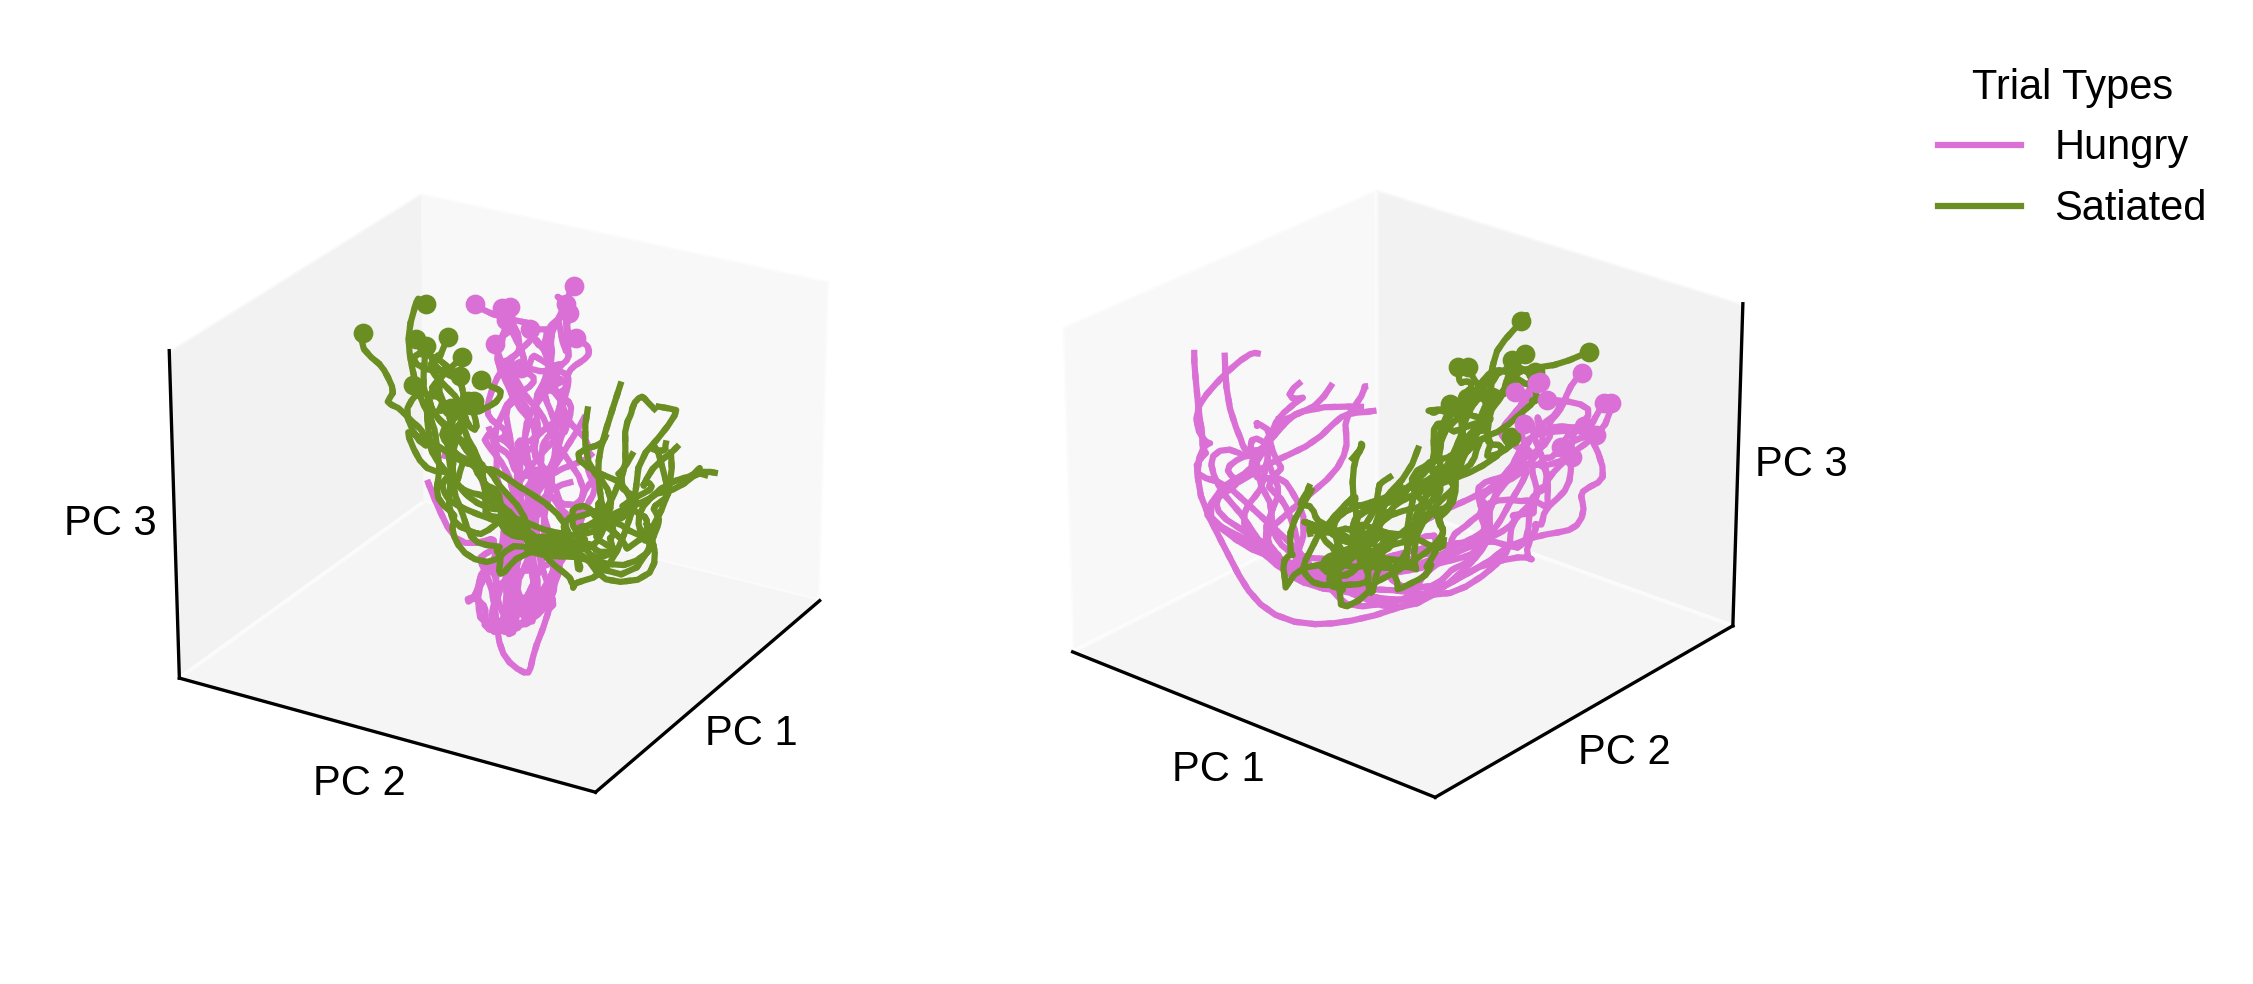

In [109]:
# pick the components corresponding to the x, y, and z axes
component_x = 0
component_y = 1
component_z = 2

# create a boolean mask so we can plot activity during stimulus as 
# solid line, and pre and post stimulus as a dashed line
stim_mask = ~np.logical_and(np.arange(trial_size) >= pre_window_size,
               np.arange(trial_size) < (trial_size))

# utility function to clean up and label the axes
def style_3d_ax(ax, labelpad=-10):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = True
    ax.zaxis.pane.fill = True
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xlabel('PC 1', labelpad=labelpad)
    ax.set_ylabel('PC 2', labelpad=labelpad)
    ax.set_zlabel('PC 3', labelpad=labelpad)
    ax.set_box_aspect(aspect=None, zoom=0.8)


colors_type = {'Hungry': 'orchid', 'Satiated': 'olivedrab'}

sigma = 1 # smoothing amount

# set up a figure with two 3d subplots, so we can have two different views
fig = plt.figure(figsize=[10, 4], dpi = 300)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axs = [ax1, ax2]

for ax in axs:
    legend_labels = []  # List to store legend labels
    for t, (trial, t_type) in enumerate(zip(projected_trials_zscored, trial_type)):
            
        x = trial[component_x, :]
        y = trial[component_y, :]
        z = trial[component_z, :]

        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)
        z = gaussian_filter1d(z, sigma=sigma)

        # use the mask to plot stimulus and pre/post stimulus separately
        z_stim = z.copy()
#         z_stim[stim_mask] = np.nan
        z_prepost = z.copy()
#         z_prepost[~stim_mask] = np.nan

        ax.plot(x, y, z_stim, c = colors_type[t_type], label= f'{t_type}' if (t == 0) or (t == trial_number) else None)
        ax.plot(x, y, z_prepost, c= colors_type[t_type], ls=':')

        # plot dots at initial point
        ax.scatter(x[0], y[0], z[0], c=colors_type[t_type], s=14)
        
        # make the axes a bit cleaner
        style_3d_ax(ax)
        
ax2.legend(title="Trial Types", bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)

# specify the orientation of the 3d plot        
ax1.view_init(elev=25, azim=30)
ax2.view_init(elev=25, azim=130)
plt.subplots_adjust(left=0, wspace = -0.5)
# plt.tight_layout()
plt.show()

/tmp/ipykernel_148346/2153141063.py:75: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[0], y[0], z[0], c=trial_color, s=14)


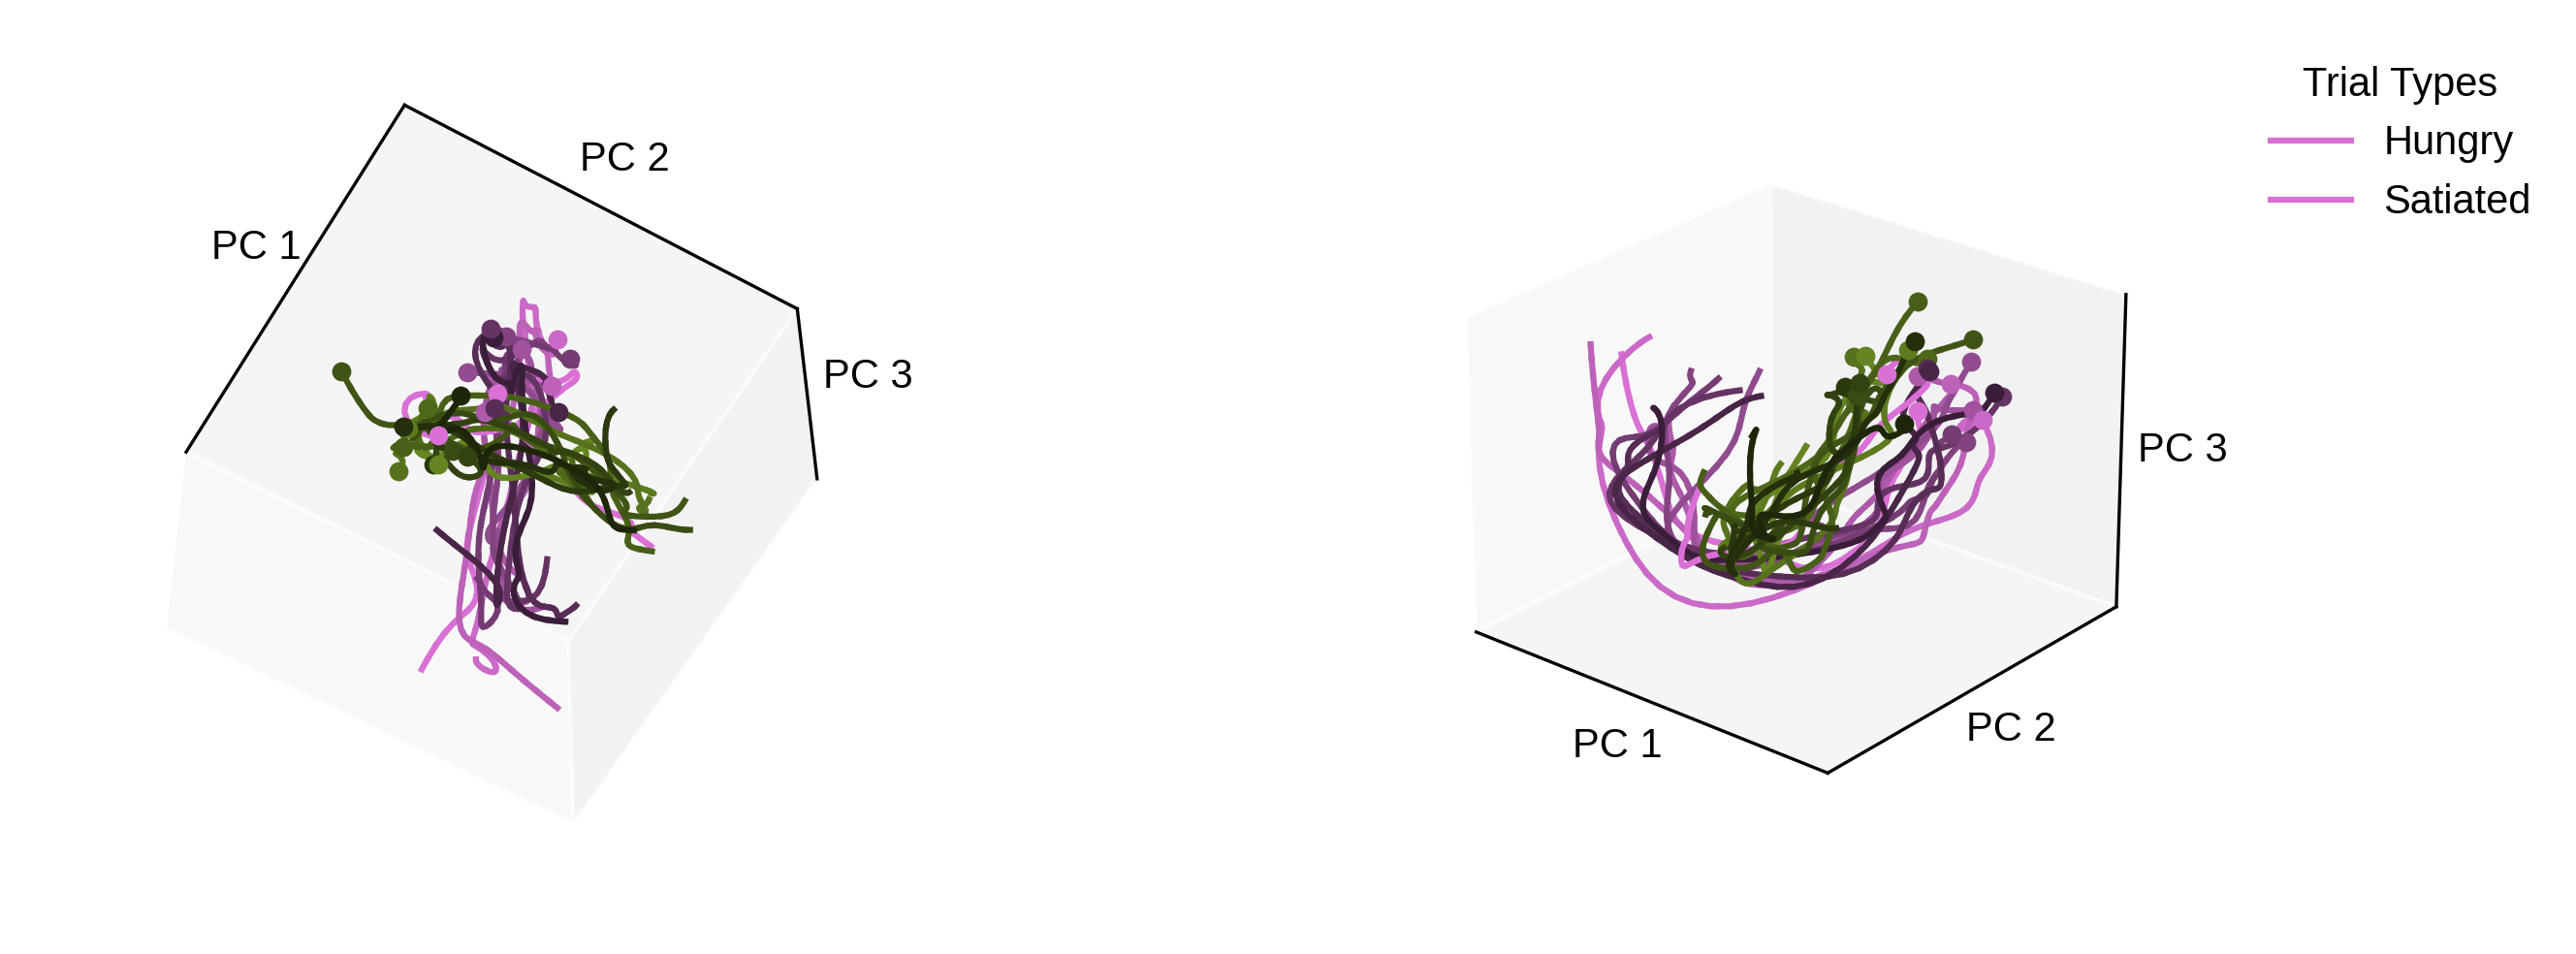

In [110]:

# pick the components corresponding to the x, y, and z axes
component_x = 0
component_y = 1
component_z = 2

# create a boolean mask so we can plot activity during stimulus as 
# solid line, and pre and post stimulus as a dashed line
stim_mask = ~np.logical_and(np.arange(trial_size) >= pre_window_size,
               np.arange(trial_size) < (trial_size))

# Convert colors to RGBA if they aren't already
rgba_colors = [mpl.colors.to_rgba(c) for c in colors]

# Define a function to create darker shades of a color
def get_darker_shade(rgba_color, shade_factor):
    # Apply the shade_factor to the RGB channels, not the alpha channel
    return (rgba_color[0] * shade_factor, rgba_color[1] * shade_factor, rgba_color[2] * shade_factor, rgba_color[3])

# utility function to clean up and label the axes
def style_3d_ax(ax, labelpad=-10):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = True
    ax.zaxis.pane.fill = True
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xlabel('PC 1', labelpad=labelpad)
    ax.set_ylabel('PC 2', labelpad=labelpad)
    ax.set_zlabel('PC 3', labelpad=labelpad)
    ax.set_box_aspect(aspect=None, zoom=0.8)




sigma = 2 # smoothing amount

# set up a figure with two 3d subplots, so we can have two different views
fig = plt.figure(figsize=[10, 4], dpi = 300)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axs = [ax1, ax2]

for ax in axs:
    legend_labels = []  # List to store legend labels
    for t, (trial, t_type) in enumerate(zip(projected_trials_zscored, trial_type)):
        base_rgba_color = rgba_colors[int((t-12)>0)]
        if t < 12:            
            shade_factor = 1 - (t / float(trial_number)) * 0.8  # Example to darken by up to 50%
        else:
            shade_factor = 1 - ((t-12) / float(trial_number)) * 0.8  # Example to darken by up to 50%
        trial_color = get_darker_shade(base_rgba_color, shade_factor)
    
        x = trial[component_x, :]
        y = trial[component_y, :]
        z = trial[component_z, :]

        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)
        z = gaussian_filter1d(z, sigma=sigma)

        # use the mask to plot stimulus and pre/post stimulus separately
        z_stim = z.copy()
#         z_stim[stim_mask] = np.nan
        z_prepost = z.copy()
#         z_prepost[~stim_mask] = np.nan

        ax.plot(x, y, z_stim, c = trial_color, label= f'{t_type}' if (t == 0) or (t == trial_number) else None)
        ax.plot(x, y, z_prepost, c= trial_color, ls=':')

        # plot dots at initial point
        ax.scatter(x[0], y[0], z[0], c=trial_color, s=14)
        
        # make the axes a bit cleaner
        style_3d_ax(ax)
        
   
        
ax2.legend(title="Trial Types", bbox_to_anchor=(1, 1), loc='upper left', frameon = False)

# specify the orientation of the 3d plot        
ax1.view_init(elev=120, azim=30)
ax2.view_init(elev=25, azim=130)
plt.subplots_adjust(left=0, wspace = 0)
# plt.tight_layout()
plt.show()

/tmp/ipykernel_148346/266140259.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_smooth[0], y_smooth[0], c=trial_color, s=6)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


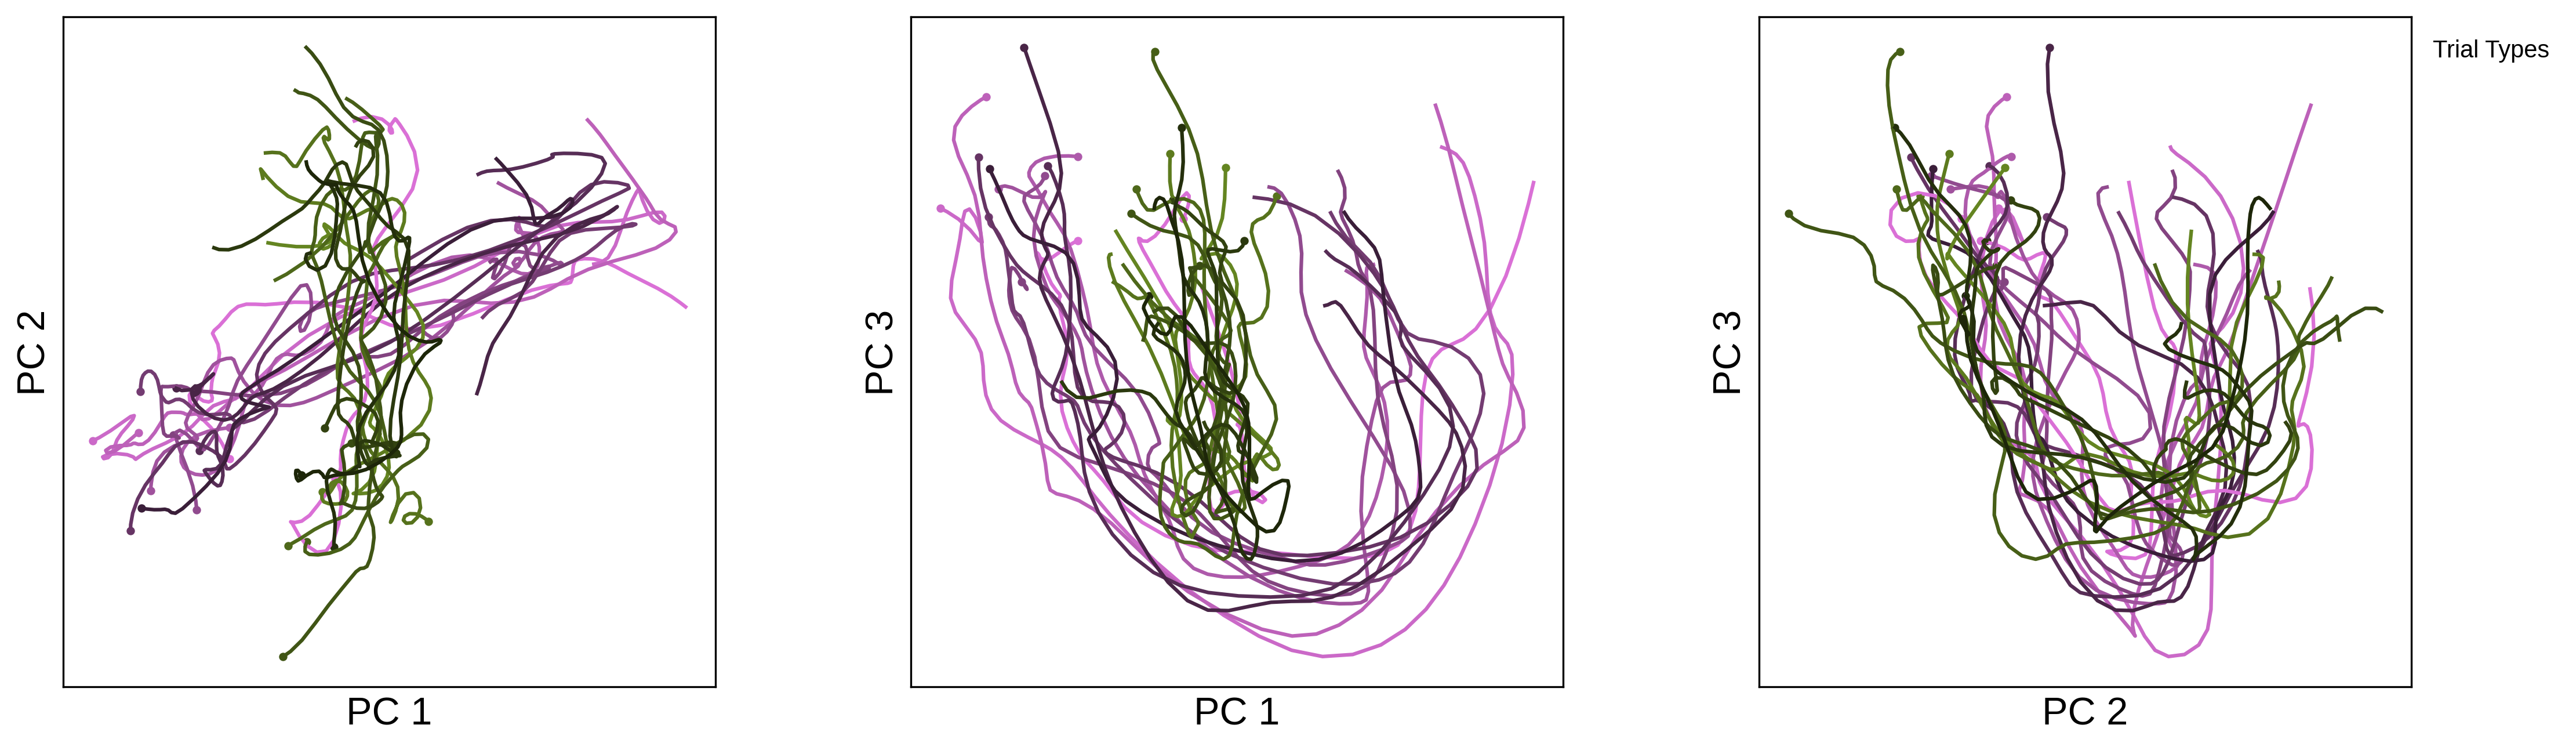

In [111]:


sigma = 1  # Smoothing amount

# Set up a figure with three 2D subplots for the different combinations of PCs
fig, axs = plt.subplots(1, 3, figsize=[15, 5], dpi=300)

# PC combinations to plot
pc_combinations = [(component_x, component_y), (component_x, component_z), (component_y, component_z)]

for ax, (pc1, pc2) in zip(axs, pc_combinations):
    legend_labels = []  # List to store legend labels
    for t, (trial, t_type) in enumerate(zip(projected_trials, trial_type)):
        base_rgba_color = rgba_colors[int((t-12)>0)]
        if t < 12:            
            shade_factor = 1 - (t / float(trial_number)) * 0.8  # Example to darken by up to 50%
        else:
            shade_factor = 1 - ((t-12) / float(trial_number)) * 0.8  # Example to darken by up to 50%
        trial_color = get_darker_shade(base_rgba_color, shade_factor)
    
        x = trial[pc1, :]
        y = trial[pc2, :]

        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)

         # Apply smoothing
        x_smooth = gaussian_filter1d(x, sigma=sigma)
        y_smooth = gaussian_filter1d(y, sigma=sigma)

        # Plotting
        ax.plot(x_smooth, y_smooth, c=trial_color, label=f'{t_type}' if i == 0 else None)
        ax.scatter(x_smooth[0], y_smooth[0], c=trial_color, s=6)


    # Style the axes (you may need to modify the style_3d_ax function for 2D plots or create a new styling function)
    style_2d_ax(ax)

# Adjusting subplot parameters and adding legend
plt.subplots_adjust(left=0, wspace=0.3)
axs[-1].legend(title="Trial Types", bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.show()


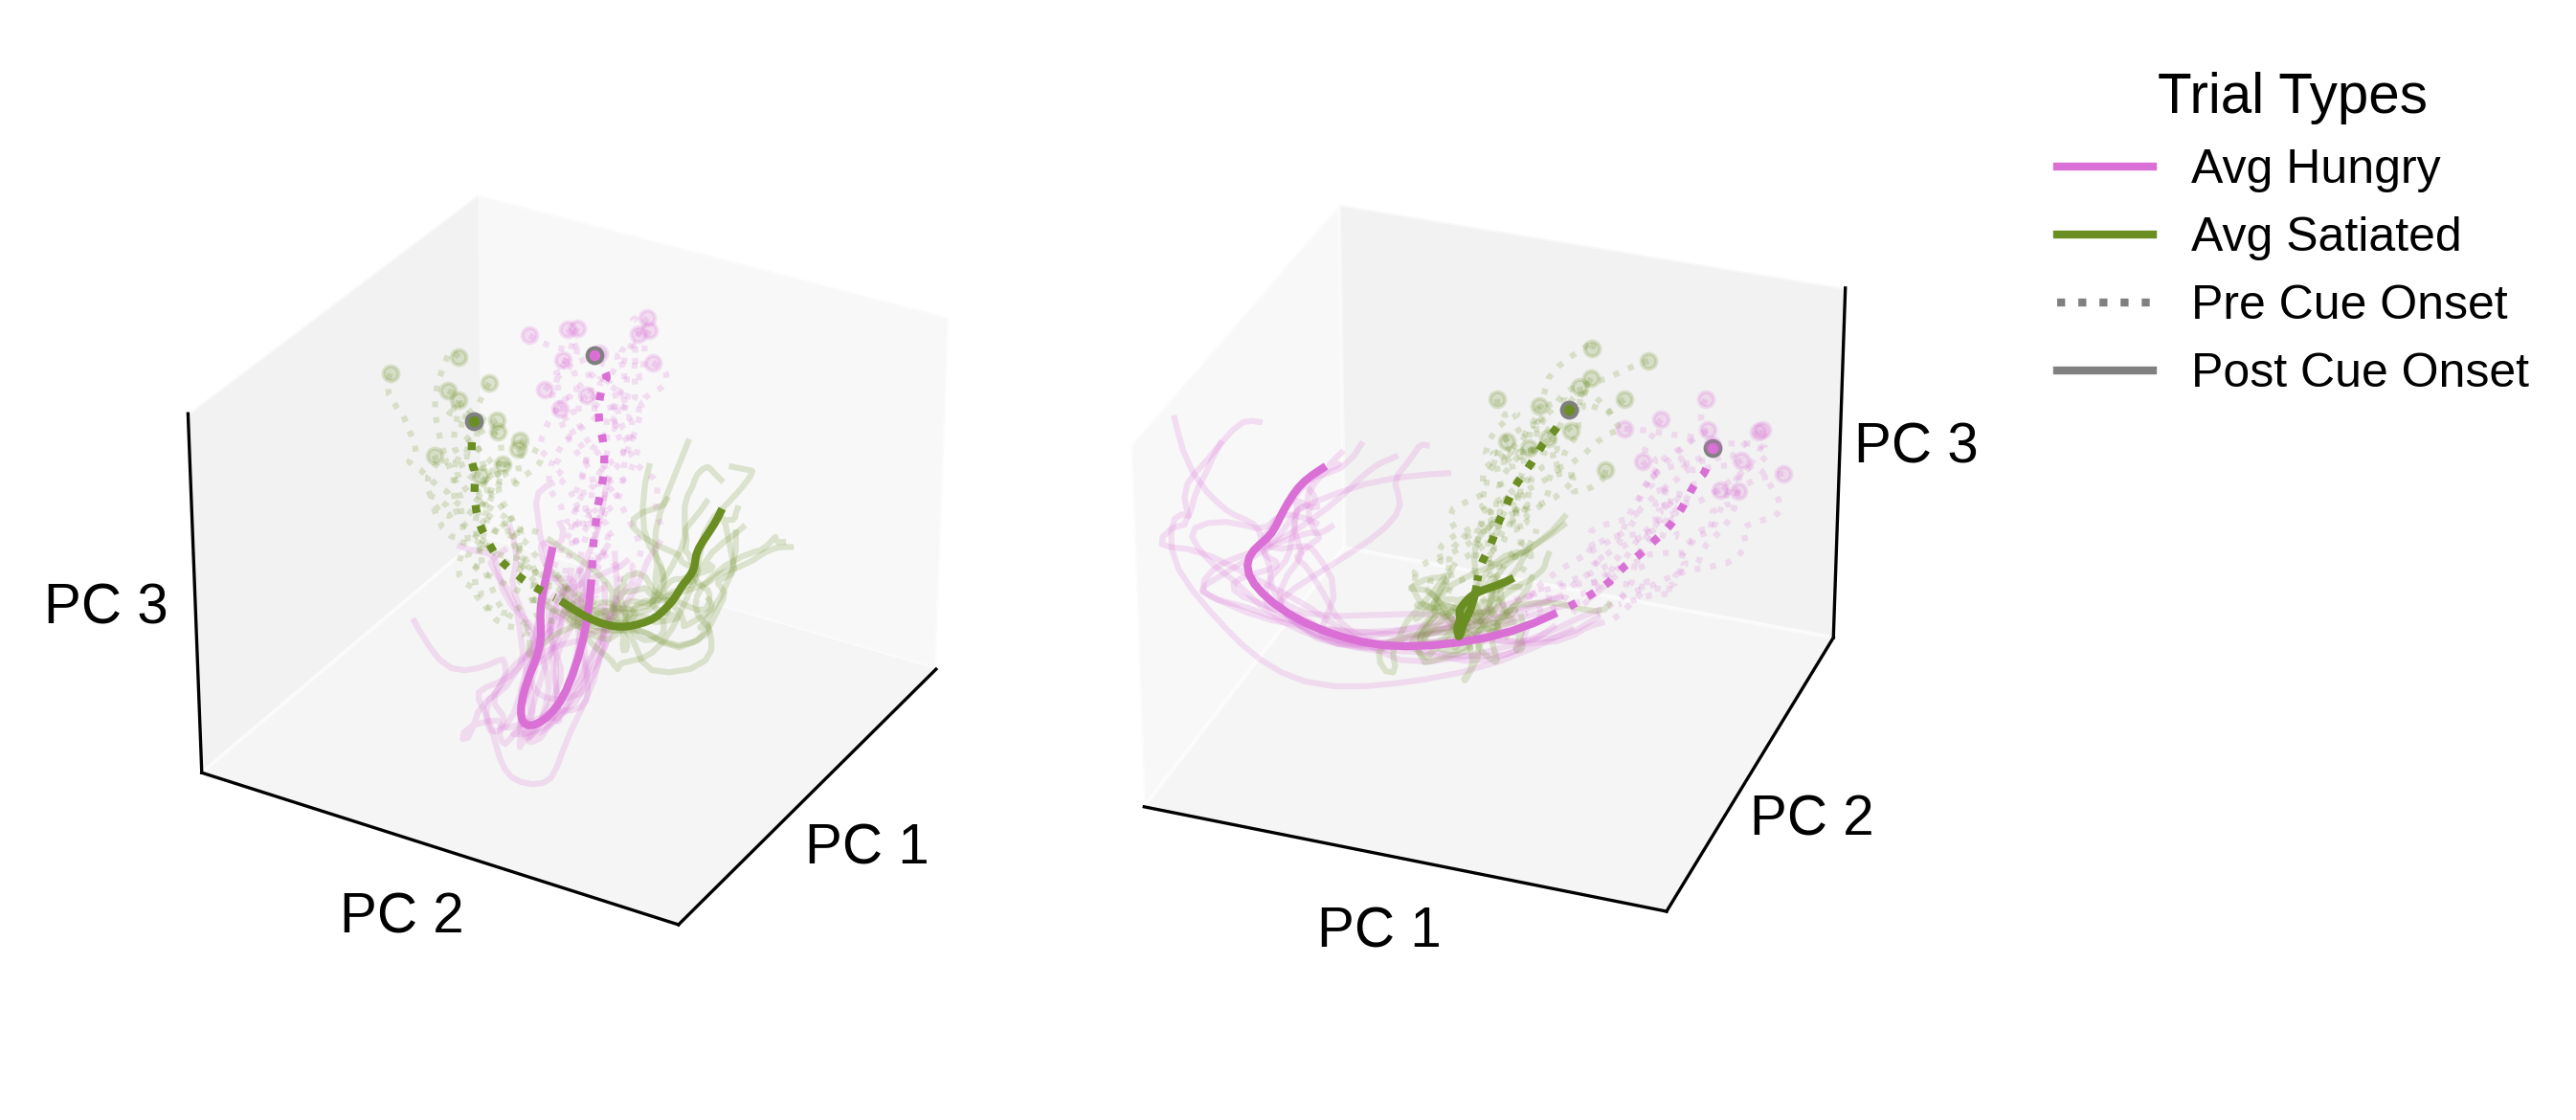

In [113]:
def style_3d_ax(ax, labelpad=-5, fontsize = 14):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = True
    ax.zaxis.pane.fill = True
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.set_xlabel('PC 1', labelpad=labelpad, fontsize = fontsize)
    ax.set_ylabel('PC 2', labelpad=labelpad, fontsize = fontsize)
    ax.set_zlabel('PC 3', labelpad=labelpad, fontsize = fontsize)
    ax.set_box_aspect(aspect=None, zoom=0.8)
    
# Set up a figure with two 3d subplots, so we can have two different views
fig = plt.figure(figsize=[10, 4], dpi=300)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axs = [ax1, ax2]
sigma = 1

# Store the data for averaging
average_data = {t_type: {'x': [], 'y': [], 'z': []} for t_type in trial_types}

# Custom legend handles
legend_handles = []

for ax in axs:
    for t, (trial, t_type) in enumerate(zip(projected_trials_zscored, trial_type)):
        base_rgba_color =  mpl.colors.to_rgba(colors_type[t_type])
        if t < 12:            
            shade_factor = 1 - (t / float(trial_number)) * 0  # Example to darken by up to 50%
        else:
            shade_factor = 1 - ((t-12) / float(trial_number)) * 0  # Example to darken by up to 50%
        trial_color = get_darker_shade(base_rgba_color, shade_factor)
        trial_color = trial_color[:3] + (0.2,)
        
        x = trial[component_x, :]
        y = trial[component_y, :]
        z = trial[component_z, :]

        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)
        z = gaussian_filter1d(z, sigma=sigma)

        # use the mask to plot stimulus and pre/post stimulus separately
        z_stim = z.copy()
        z_stim[stim_mask] = np.nan
        z_prepost = z.copy()
        z_prepost[~stim_mask] = np.nan

        ax.plot(x, y, z_stim, c = trial_color, label= f'{t_type}' if (t == 0) or (t == trial_number) else None)
        ax.plot(x, y, z_prepost, c= trial_color, ls=':')
        # plot dots at initial point
        ax.scatter(x[0], y[0], z[0], color=trial_color, s=14, edgecolor = trial_color)


        # Accumulate data for averaging
        average_data[t_type]['x'].append(x)
        average_data[t_type]['y'].append(y)
        average_data[t_type]['z'].append(z)
    
    for t_type in trial_types:

        # Calculate and plot the average trace for each trial type
        avg_x = np.mean(average_data[t_type]['x'], axis=0)
        avg_y = np.mean(average_data[t_type]['y'], axis=0)
        avg_z = np.mean(average_data[t_type]['z'], axis=0)

        # Apply smoothing
        avg_x_smooth = gaussian_filter1d(avg_x, sigma=sigma)
        avg_y_smooth = gaussian_filter1d(avg_y, sigma=sigma)
        avg_z_smooth = gaussian_filter1d(avg_z, sigma=sigma)
        
        avg_z_stim = avg_z_smooth.copy()
        avg_z_stim[stim_mask] = np.nan
        avg_z_prepost = avg_z_smooth.copy()
        avg_z_prepost[~stim_mask] = np.nan

        # Plotting the average trace
        ax.plot(avg_x_smooth, avg_y_smooth, avg_z_stim, c=colors_type[t_type], linewidth=2, label=f'Avg {t_type}')
        ax.plot(avg_x_smooth, avg_y_smooth, avg_z_prepost, c=colors_type[t_type], ls = ':', linewidth=2)

        ax.scatter(avg_x_smooth[0], avg_y_smooth[0], avg_z_smooth[0], color=colors_type[t_type], s = 14, edgecolor = 'grey')

    # Style the axes
    style_3d_ax(ax)

line_styles = [
    Line2D([0], [0], color='gray', lw=2, linestyle=':', label='Pre Cue Onset'),
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Post Cue Onset')
]

legend_handles = [Line2D([0], [0], color=colors_type[t_type], lw=2, label=f'Avg {t_type}') for t_type in trial_types]
legend_handles.extend(line_styles)


# Adding legend and final adjustments
ax2.legend(handles=legend_handles, title="Trial Types", bbox_to_anchor=(1, 1), loc='upper left', frameon=False,  title_fontsize=14, fontsize = 12)
ax1.view_init(elev=30, azim=30)
ax2.view_init(elev=30, azim=110)
ax1.set_ylim(-10, 10)
ax1.set_xlim(-10, 10)
ax1.set_zlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.set_xlim(-10, 10)
ax2.set_zlim(-10, 10)
plt.subplots_adjust(left=0, wspace=-0.55)

plt.tight_layout()
plt.savefig("/scratch/09117/xz6783/Xu/Plots/Fig2/fig2_satiation_trajectory.svg", transparent=True)

plt.show()


  



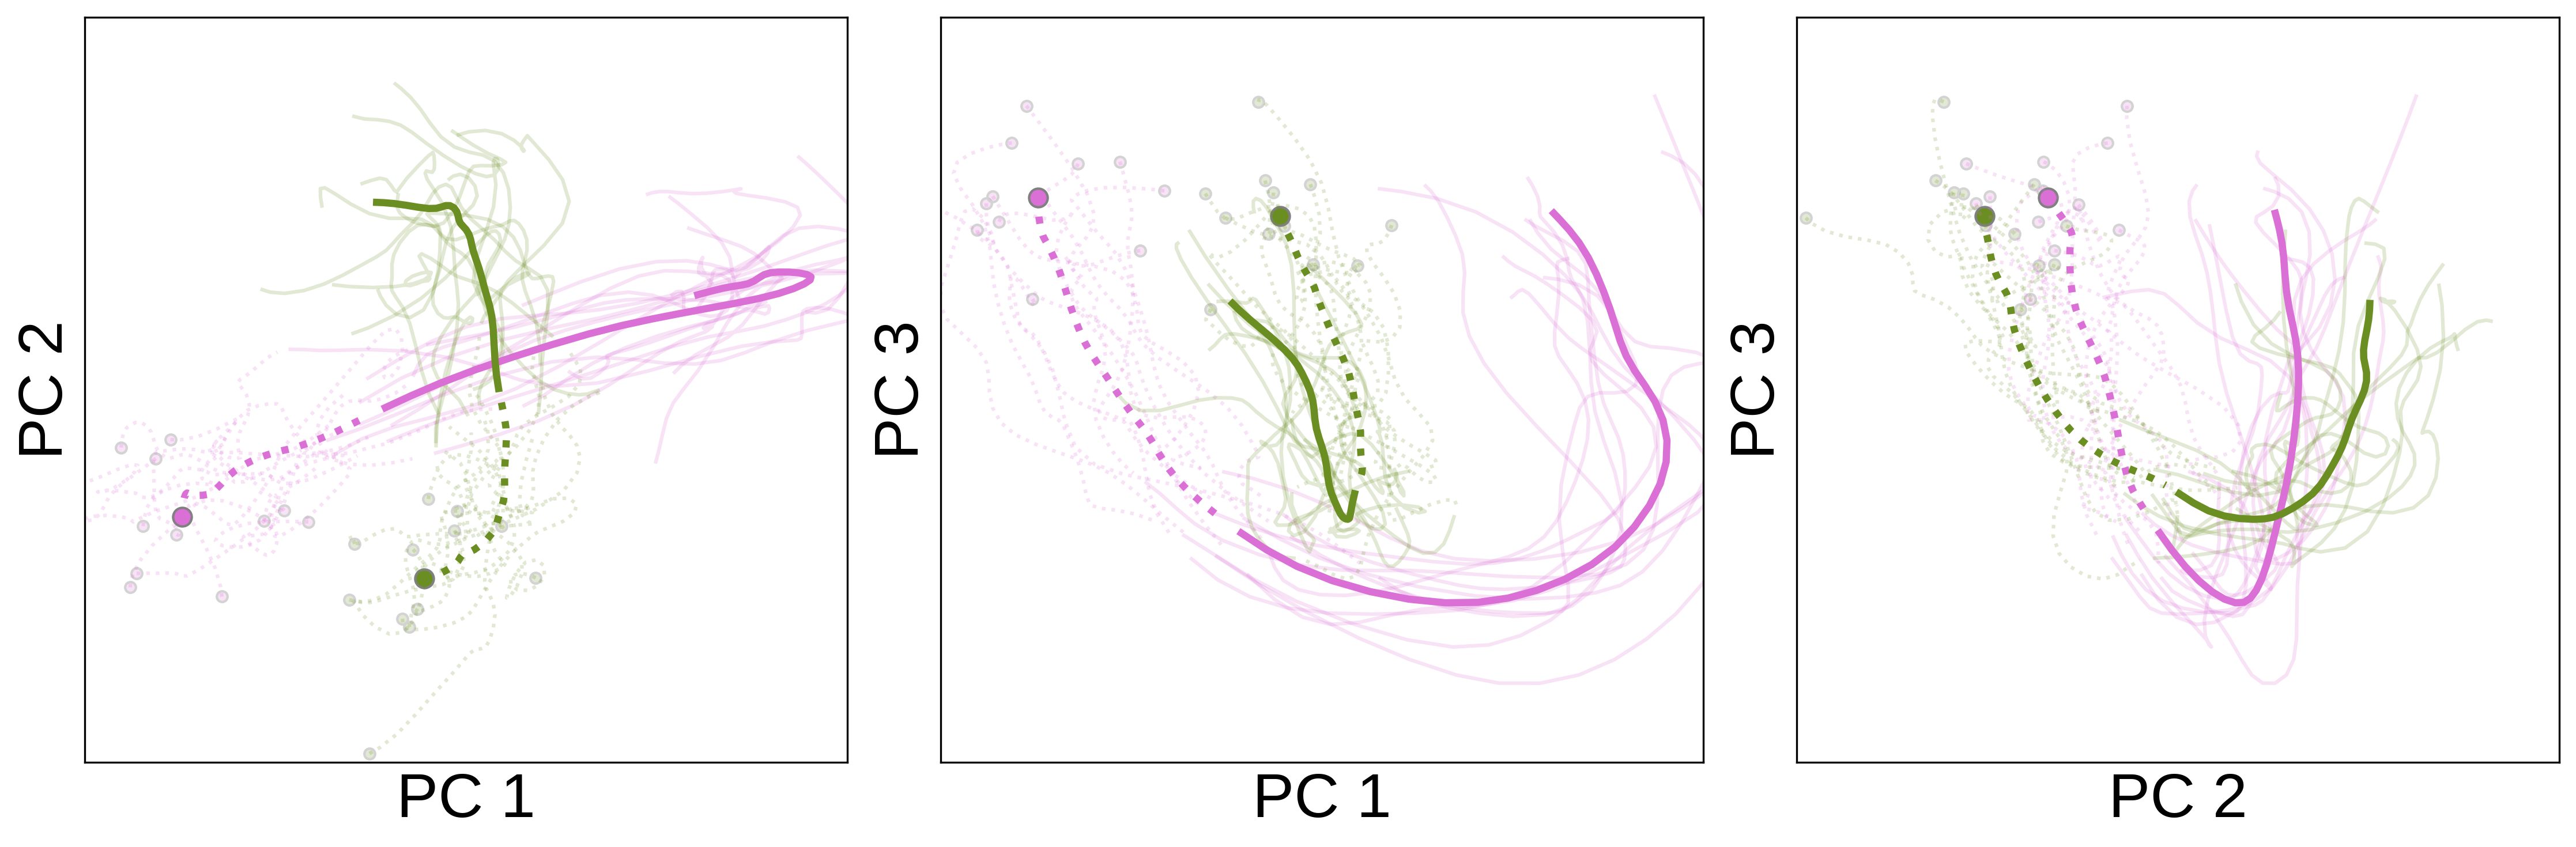

In [114]:
sigma = 1  # Smoothing amount

def style_2d_ax(ax, ):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f'PC {pc1+1}', fontsize = 26)
    ax.set_ylabel(f'PC {pc2+1}', fontsize = 26)


# Set up a figure with three 2D subplots for the different combinations of PCs
fig, axs = plt.subplots(1, 3, figsize=[15, 5], dpi=300)

# PC combinations to plot
pc_combinations = [(component_x, component_y), (component_x, component_z), (component_y, component_z)]

for ax, (pc1, pc2) in zip(axs, pc_combinations):
    average_data = {t_type: {'x': [], 'y': []} for t_type in trial_types}

    for t, (trial, t_type) in enumerate(zip(projected_trials_zscored, trial_type)):
        base_rgba_color =  mpl.colors.to_rgba(colors_type[t_type])
        if t < 12:            
            shade_factor = 1 - (t / float(trial_number)) * 0  # Example to darken by up to 50%
        else:
            shade_factor = 1 - ((t-12) / float(trial_number)) * 0  # Example to darken by up to 50%
        trial_color = get_darker_shade(base_rgba_color, shade_factor)
        trial_color = trial_color[:3] + (0.2,)
    
        x = trial[pc1, :]
        y = trial[pc2, :]

        # apply some smoothing to the trajectories
        x = gaussian_filter1d(x, sigma=sigma)
        y = gaussian_filter1d(y, sigma=sigma)


         # Apply smoothing
        x_smooth = gaussian_filter1d(x, sigma=sigma)
        y_smooth = gaussian_filter1d(y, sigma=sigma)
        
        y_stim = y_smooth.copy()
        y_stim[stim_mask] = np.nan
        y_prepost = y_smooth.copy()
        y_prepost[~stim_mask] = np.nan

        # Plotting
        ax.plot(x_smooth, y_stim, color=trial_color, label=f'{t_type}' if (t == 0) or (t == trial_number) else None)
        ax.plot(x_smooth, y_prepost, color=trial_color, ls=':')

        ax.scatter(x_smooth[0], y_smooth[0], color=trial_color, s=20, edgecolor = 'lightgrey')
                    
        # Accumulate data for averaging
        average_data[t_type]['x'].append(x)
        average_data[t_type]['y'].append(y)
        
    for t_type in trial_types:
        
        # Calculate and plot the average trace for each trial type
        avg_x = np.mean(average_data[t_type]['x'], axis=0)
        avg_y = np.mean(average_data[t_type]['y'], axis=0)

        # Apply smoothing
        avg_x_smooth = gaussian_filter1d(avg_x, sigma=sigma)
        avg_y_smooth = gaussian_filter1d(avg_y, sigma=sigma)
        
        avg_y_stim = avg_y_smooth.copy()
        avg_y_stim[stim_mask] = np.nan
        avg_y_prepost = avg_y_smooth.copy()
        avg_y_prepost[~stim_mask] = np.nan

        # Plotting the average trace
        ax.plot(avg_x_smooth, avg_y_stim, color=colors_type[t_type], linewidth=3, label=f'Avg {t_type}')
        ax.plot(avg_x_smooth, avg_y_prepost, color=colors_type[t_type], linewidth=3, ls = ':')

        ax.scatter(avg_x_smooth[0], avg_y_smooth[0], color=colors_type[t_type], s=60, edgecolor = 'grey')

    # Style the axes (you may need to modify the style_3d_ax function for 2D plots or create a new styling function)
    style_2d_ax(ax)
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)

line_styles = [
    Line2D([0], [0], color='gray', lw=2, linestyle=':', label='Pre Cue Onset'),
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Post Cue Onset')
]

legend_handles = [Line2D([0], [0], color=colors_type[t_type], lw=2, label=f'Avg {t_type}') for t_type in trial_types]
legend_handles.extend(line_styles)

# Adjusting subplot parameters and adding legend
plt.subplots_adjust(left=0, wspace=0.2)
# axs[-1].legend(handles=legend_handles, title="Trial Types", bbox_to_anchor=(1, 1), loc='upper left', frameon=False, title_fontsize=22, fontsize = 20)
plt.tight_layout()
plt.savefig("/scratch/09117/xz6783/Xu/Plots/Fig2/fig2_satiation_trajectory_2d.svg", transparent=True)

plt.show()